In [62]:
# %%
# Cell 1: Imports & Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# Configuration
SAVE_DIR = "Saved_files_new"
plt.style.use('default')
sns.set_palette("husl")

print(f"Visualization setup complete. Using save directory: {SAVE_DIR}")


Visualization setup complete. Using save directory: Saved_files_new


## Data Loading Functions


In [63]:
# %%
# Cell 2: Enhanced Data Loading Functions with Topic-Specific N-grams
def try_read_csv(file_path, sep_choices=(';', ',')):
    """Try to read CSV with different separators for robustness."""
    for sep in sep_choices:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            if len(df.columns) == 1 and ',' in df.columns[0]:
                continue
            return df
        except Exception:
            continue
    raise ValueError(f"Could not load {file_path} with any separator.")

def load_complete_analysis_data(date_string, save_dir="Saved_files_new"):
    """
    Load analyzed DataFrame with enhanced file pattern matching.
    Matches the actual file naming convention from the method detection pipeline.
    Now includes topic-specific n-grams loading.
    """
    print(f"Loading complete analysis data for {date_string}...")
    print(f"Searching in directory: {save_dir}")
    
    if not os.path.exists(save_dir):
        print(f"❌ Directory {save_dir} does not exist!")
        return None
    
    try:
        # Primary file patterns (matching refactored method detection pipeline)
        possible_files = [
            f"enhanced_method_analysis_{date_string}.csv",
            f"semantic_scholar_{date_string}_all_results.csv",
            f"semantic_scholar_{date_string}_enhanced_analysis.csv",
            f"semantic_scholar_{date_string}_results.csv",
            f"{date_string}_enhanced_analysis.csv",
            f"{date_string}_results.csv"
        ]
        
        df_filename = None
        print("  Checking for main analysis file...")
        for base in possible_files:
            potential_path = os.path.join(save_dir, base)
            if os.path.exists(potential_path):
                df_filename = potential_path
                print(f"  ✅ Found: {base}")
                break
            else:
                print(f"  ❌ Not found: {base}")
        
        if df_filename is None:
            print(f"\n📁 Available CSV files in {save_dir}:")
            csv_files = [f for f in os.listdir(save_dir) if f.endswith('.csv')]
            for f in sorted(csv_files):
                print(f"    📄 {f}")
            raise FileNotFoundError(f"No analyzed CSV file found for {date_string}")
        
        # Load main DataFrame
        df_analyzed = try_read_csv(df_filename)
        print(f"  ✅ Loaded DataFrame: {df_analyzed.shape}")
        print(f"  📊 Columns: {list(df_analyzed.columns)}")
        
        # Load topic metadata
        topic_keywords = topic_names = method_groups = None
        
        topic_file_patterns = [
            f"topics_{date_string}.json",
            f"topic_names_{date_string}.json", 
            f"semantic_scholar_{date_string}_topic_names.json",
            f"method_variant_groups_{date_string}.json",
            f"{date_string}_topics.json",
            f"{date_string}_topic_names.json"
        ]
        
        print("  Checking for topic metadata...")
        for pattern in topic_file_patterns:
            topic_path = os.path.join(save_dir, pattern)
            if os.path.exists(topic_path):
                print(f"  ✅ Found topic file: {pattern}")
                try:
                    with open(topic_path, 'r', encoding='utf-8') as f:
                        topic_data = json.load(f)
                        
                    if isinstance(topic_data, dict):
                        if 'topics' in topic_data:
                            topic_keywords = topic_data['topics']
                            topic_names = topic_data.get('topic_names', None)
                        elif 'topic_names' in topic_data:
                            topic_names = topic_data['topic_names']
                        else:
                            # Assume it's directly topic names or method groups
                            if any('topic' in str(k).lower() for k in topic_data.keys()):
                                topic_names = topic_data
                            else:
                                method_groups = topic_data
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        # Try to load term frequencies
        term_freq_patterns = [
            f"term_frequencies_{date_string}.json",
            f"{date_string}_term_frequencies.json",
            "term_frequencies.json"
        ]
        
        term_frequencies_file = None
        for pattern in term_freq_patterns:
            freq_path = os.path.join(save_dir, pattern)
            if os.path.exists(freq_path):
                term_frequencies_file = pattern
                print(f"  ✅ Found term frequencies: {pattern}")
                break
        
        if not term_frequencies_file:
            print("  ⚠️  No term frequencies file found")
        
        # ADDED: Try to load topic-specific TF-IDF n-grams
        topic_ngram_patterns = [
            f"topic_specific_tfidf_ngrams_{date_string}.json",
            f"topic_tfidf_ngrams_{date_string}.json",
            f"{date_string}_topic_ngrams.json",
            f"topic_ngrams_{date_string}.json",
            f"semantic_scholar_{date_string}_topic_ngrams.json"
        ]
        
        topic_specific_tfidf_ngrams = None
        print("  Checking for topic-specific n-grams...")
        for pattern in topic_ngram_patterns:
            ngram_path = os.path.join(save_dir, pattern)
            if os.path.exists(ngram_path):
                print(f"  ✅ Found topic n-grams: {pattern}")
                try:
                    with open(ngram_path, 'r', encoding='utf-8') as f:
                        topic_specific_tfidf_ngrams = json.load(f)
                    print(f"    📊 Loaded n-grams for {len(topic_specific_tfidf_ngrams)} topics")
                    break
                except Exception as e:
                    print(f"    ⚠️  Error loading {pattern}: {e}")
                    continue
        
        if not topic_specific_tfidf_ngrams:
            print("  ⚠️  No topic-specific n-grams found")
        
        result = {
            'df_analyzed': df_analyzed,
            'topic_names': topic_names,
            'topic_keywords': topic_keywords,
            'method_groups': method_groups,
            'term_frequencies_file': term_frequencies_file,
            'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams,
        }
        
        print(f"✅ Successfully loaded analysis data!")
        return result
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# %%
# Helper Function: Access Topic-Specific N-grams
def get_topic_ngrams(topic_id, ngram_type='keywords', top_n=10, topic_specific_tfidf_ngrams=None):
    """
    Get top n-grams for a specific topic.
    
    Parameters:
    - topic_id: Topic identifier (int or str)
    - ngram_type: Type of n-grams ('keywords', 'bigrams', 'trigrams')
    - top_n: Number of top n-grams to return
    - topic_specific_tfidf_ngrams: The loaded n-grams data
    
    Returns:
    - List of tuples (term, score) or None if not found
    """
    if not topic_specific_tfidf_ngrams:
        print("❌ No topic-specific n-grams data available")
        return None
    
    topic_key = str(topic_id)
    if topic_key not in topic_specific_tfidf_ngrams:
        print(f"❌ Topic {topic_id} not found in n-grams data")
        return None
    
    topic_data = topic_specific_tfidf_ngrams[topic_key]
    if ngram_type not in topic_data:
        print(f"❌ N-gram type '{ngram_type}' not found for topic {topic_id}")
        print(f"Available types: {list(topic_data.keys())}")
        return None
    
    ngrams = topic_data[ngram_type]
    if isinstance(ngrams, dict):
        # Sort by score (assuming scores are values)
        sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True)
        return sorted_ngrams[:top_n]
    else:
        print(f"❌ Unexpected n-grams format for topic {topic_id}")
        return None




## Plotting functions

### Global N-gram Frequency Plot

In [64]:
# %%
# Cell 3: Global N-gram Frequency Plot
def plot_term_frequencies(filename, n_terms=15, save=False, save_dir=SAVE_DIR):
    """
    Enhanced term frequency plotting with better error handling.
    """
    if not filename:
        print("❌ No term frequencies filename provided")
        return
        
    file_prefix = filename.replace('.json', '')
    
    possible_paths = [
        os.path.join(save_dir, filename),
        os.path.join(save_dir, f"{filename}.json") if not filename.endswith('.json') else os.path.join(save_dir, filename)
    ]
    
    filepath = None
    for path in possible_paths:
        if os.path.exists(path):
            filepath = path
            break
    
    if filepath is None:
        print(f"❌ Could not find term frequencies file: {filename}")
        json_files = [f for f in os.listdir(save_dir) if f.endswith('.json')]
        print(f"📁 Available JSON files:")
        for f in sorted(json_files):
            print(f"    📄 {f}")
        return
    
    print(f"📈 Loading term frequencies from: {os.path.basename(filepath)}")
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            frequencies = json.load(f)
    except Exception as e:
        print(f"❌ Error loading frequencies: {e}")
        return
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    categories = ['keywords', 'bigrams', 'trigrams']
    titles = [f"Top {n_terms} Keywords", f"Top {n_terms} Bigrams", f"Top {n_terms} Trigrams"]
    colors = ['steelblue', 'darkgreen', 'darkred']
    
    for ax, cat, title, color in zip([ax1, ax2, ax3], categories, titles, colors):
        freq_dict = frequencies.get(cat, {})
        if not freq_dict:
            ax.text(0.5, 0.5, f'No {cat} data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title)
            continue
            
        top_terms = list(freq_dict.keys())[:n_terms]
        top_freqs = [freq_dict[t] for t in top_terms]
        
        bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel("Number of Occurrences in Corpus")
        ax.invert_yaxis()
        
        # Add value labels on bars
        for bar, freq in zip(bars, top_freqs[::-1]):
            width = bar.get_width()
            ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2, 
                   str(freq), ha='left', va='center', fontsize=9)
        
        for label in ax.get_yticklabels(): 
            label.set_fontsize(10)
    
    plt.suptitle("Global Term Frequency Analysis", fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        output_file = os.path.join(save_dir, f"{file_prefix}_plots.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"💾 Plot saved as: {output_file}")
    
    plt.show()


### Per-Topic N-gram Frequency Plot

In [65]:
# %%
# Cell 4: Per-Topic N-gram Frequency Plot
def plot_top_terms_for_topic(df, topic_idx, topic_name=None, text_col='processed_text',
                            n_keywords=10, n_bigrams=10, n_trigrams=10, save=False, 
                            prefix='', save_dir=SAVE_DIR):
    """
    Enhanced per-topic term frequency plotting.
    """
    if 'Primary_Topic_Index' in df.columns:
        topic_df = df[df['Primary_Topic_Index'] == topic_idx]
    elif 'Primary_Topic' in df.columns:
        topic_df = df[df['Primary_Topic'] == topic_idx]
    else:
        print("❌ No topic column found in DataFrame")
        return
    
    if topic_df.empty:
        print(f"❌ No documents found for topic {topic_idx}")
        return
    
    print(f"📊 Analyzing {len(topic_df)} documents for topic {topic_idx}")
    
    text_list = topic_df[text_col].fillna('').astype(str).tolist()
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
    
    topic_display_name = topic_name or f"Topic {topic_idx}"
    titles = [
        f"Top {n_keywords} Keywords",
        f"Top {n_bigrams} Bigrams", 
        f"Top {n_trigrams} Trigrams"
    ]
    
    colors = ['steelblue', 'darkgreen', 'darkred']
    ngram_configs = [(1,1), (2,2), (3,3)]
    n_tops = [n_keywords, n_bigrams, n_trigrams]
    
    for (ngram, ax, title, color, n_top) in zip(ngram_configs, [ax1, ax2, ax3], titles, colors, n_tops):
        try:
            vec = CountVectorizer(ngram_range=ngram, stop_words='english', max_features=1000)
            mat = vec.fit_transform(text_list)
            terms = vec.get_feature_names_out()
            freqs = mat.sum(axis=0).A1
            
            top_idx = freqs.argsort()[::-1][:n_top]
            top_terms = [terms[i] for i in top_idx]
            top_freqs = [int(freqs[i]) for i in top_idx]
            
            bars = ax.barh(top_terms[::-1], top_freqs[::-1], color=color, alpha=0.7)
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel("Number of Occurrences (in Topic)")
            ax.invert_yaxis()
            
            # Add value labels
            for bar, freq in zip(bars, top_freqs[::-1]):
                width = bar.get_width()
                ax.text(width + 0.01 * max(top_freqs), bar.get_y() + bar.get_height()/2,
                       str(freq), ha='left', va='center', fontsize=9)
                       
            for label in ax.get_yticklabels(): 
                label.set_fontsize(10)
                
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)[:50]}...', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(title, fontweight='bold')
    
    plt.suptitle(f'Term Analysis for {topic_display_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    if save:
        safe_name = str(topic_display_name).replace(' ', '_').replace('/', '_').replace('\\', '_')
        fig_name = f"{prefix}topic_{topic_idx}_{safe_name}_termfrequencies.png"
        fig_path = os.path.join(save_dir, fig_name)
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        print(f"💾 Per-topic plot saved as: {fig_path}")
    
    plt.show()


###  Method Importance Barplot

In [66]:
# %%
# Cell 5: Method Importance Barplot
def plot_method_importance(df, method_col='Primary_Method', min_count=2, include_low_conf=False,
                          figsize=(14, 8), max_methods=20):
    """
    Enhanced method importance plotting with better formatting.
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence if column exists and include_low_conf is False
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
        conf_info = f" (excluding low confidence)"
    else:
        df_use = df
        conf_info = ""
    
    # Get method counts
    method_counts = df_use[method_col].value_counts()
    method_counts = method_counts[method_counts >= min_count]
    method_counts = method_counts.head(max_methods)  # Limit display
    
    if method_counts.empty:
        print(f"❌ No methods found with min_count >= {min_count}")
        return
    
    print(f"📊 Plotting {len(method_counts)} methods{conf_info}")
    
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(method_counts)), method_counts.values, 
                   color='mediumseagreen', alpha=0.7, edgecolor='darkgreen')
    
    plt.xticks(range(len(method_counts)), method_counts.index, 
               rotation=45, ha='right', fontsize=10)
    plt.ylabel('Number of Papers', fontsize=12)
    plt.title(f'Method Importance (Papers per Method){conf_info}', 
              fontsize=14, fontweight='bold')
    
    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, method_counts.values)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                str(count), ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return method_counts


### Topic Importance Barplot

In [67]:
# %%
# Cell 6: Topic Importance Barplot
def get_topic_name(topic_idx, topic_names):
    """Helper function to get topic name with fallback."""
    if not topic_names:
        return f"Topic {topic_idx}"
    return topic_names.get(str(topic_idx), f"{topic_idx}")

def plot_topic_importance_with_names(df, topic_names=None, figsize=(14, 8), max_topics=15):
    """
    Enhanced topic importance plotting with better formatting.
    """
    # Determine topic column
    topic_col = None
    if 'Primary_Topic' in df.columns:
        topic_col = 'Primary_Topic'
    elif 'Primary_Topic_Index' in df.columns:
        topic_col = 'Primary_Topic_Index'
    else:
        print("❌ No topic column found in DataFrame!")
        print(f"📊 Available columns: {list(df.columns)}")
        return
    
    topic_counts = df[topic_col].value_counts().head(max_topics)
    
    if topic_counts.empty:
        print("❌ No topics found in DataFrame")
        return
    
    print(f"📊 Plotting {len(topic_counts)} topics")
    
    plt.figure(figsize=figsize)
    bars = plt.bar(range(len(topic_counts)), topic_counts.values, 
                   color='lightcoral', alpha=0.7, edgecolor='darkred')
    
    # Create topic labels
    topic_labels = [get_topic_name(t, topic_names) for t in topic_counts.index]
    
    plt.xticks(range(len(topic_counts)), topic_labels, rotation=45, ha='right', fontsize=10)
    plt.title('Topic Importance (Number of Papers per Topic)', fontsize=14, fontweight='bold')
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    
    # Add value labels on bars
    for bar, count in zip(bars, topic_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(count), ha='center', va='bottom', fontsize=9)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return topic_counts


###  Method Trends Over Time

In [68]:
# %%
# Cell 7: Enhanced Method Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_method_trends_over_time(df, method_col='Primary_Method', year_col='year', 
                               methods=None, include_low_conf=False, min_count=2, 
                               min_papers_per_year=20,top_n=10, window_smooth=1, figsize=(14, 8),
                               plot_type='line', value_type='fraction', start_year=None, 
                               end_year=None, min_citations=None, venues=None):
    """
    Enhanced method trends plotting with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned methods (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[method_col].notna() & (df_filtered[method_col] != '')]
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df_filtered.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df_filtered[~df_filtered[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df_filtered
    
    # Filter by methods
    if methods is not None:
        if isinstance(methods, str): 
            methods = [methods]
        df_use = df_use[df_use[method_col].isin(methods)]
        label = f"Methods: {', '.join(methods)}"
    else:
        value_counts = df_use[method_col].value_counts()
        methods = value_counts[value_counts >= min_count].head(top_n).index.tolist()
        label = f"Top {len(methods)} Methods"
        df_use = df_use[df_use[method_col].isin(methods)]
    
    if df_use.empty:
        print("❌ No matching method assignments to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends - KEY CHANGE: Use df_filtered (all papers) for total counts
    year_method_counts = df_use.groupby([year_col, method_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')  # All papers, not just selected methods
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    merged = pd.merge(year_method_counts, valid_years, on=year_col)
    
    # FIXED: Calculate values based on value_type against ALL papers
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']  # Fraction of ALL papers
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([method_col, year_col])
        merged['value'] = merged.groupby(method_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=method_col, values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[method_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        plot_data = merged.copy()
        plot_data[method_col] = plot_data[method_col].astype(str)
        all_methods = sorted(plot_data[method_col].unique())
        
        sns.lineplot(data=plot_data, x=year_col, y='value', hue=method_col, 
                    marker='o', linewidth=2, ax=ax, hue_order=all_methods, legend='full')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create title with filtering info
    title_parts = [f'Method Usage Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged


### Topic Trends Over Time

In [69]:
# %%
# Cell 8: Enhanced Topic Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_topic_trends_over_time(df, topic_col=None, year_col='year', topics=None, 
                               top_n=10, min_papers_per_year=20, window_smooth=1, 
                               topic_names=None, figsize=(14, 8), plot_type='line',
                               start_year=None, end_year=None, value_type='fraction',
                               min_citations=None, venues=None):
    """
    Enhanced topic trends plotting with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        elif 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        else:
            print("❌ No topic column found!")
            return
    
    if year_col not in df.columns:
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    # Start with copy of dataframe
    df_filtered = df.copy()
    
    # Apply year filtering first
    if start_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] >= start_year]
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Remove papers without assigned topics (for fraction calculation base)
    df_filtered = df_filtered[df_filtered[topic_col].notna() & (df_filtered[topic_col] != '')]
    
    print(f"📅 Year range: {df_filtered[year_col].min()} - {df_filtered[year_col].max()}")
    
    # Filter by topics
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
        label = ", ".join([get_topic_name(t, topic_names) for t in topics])
    else:
        topic_counts = df_filtered[topic_col].value_counts().nlargest(top_n)
        topics = topic_counts.index.tolist()
        label = f"Top {top_n} Topics"
        df_use = df_filtered[df_filtered[topic_col].isin(topics)]
    
    if df_use.empty:
        print("❌ No matching topics to plot.")
        return
    
    print(f"📈 Plotting trends for: {label}")
    print(f"📊 Papers after all filtering: {len(df_use)}")
    
    # Calculate trends - KEY CHANGE: Use df_filtered (all papers) for total counts
    year_topic_counts = df_use.groupby([year_col, topic_col]).size().reset_index(name='count')
    year_totals = df_filtered.groupby(year_col).size().reset_index(name='total_count')  # All papers, not just selected topics
    
    # Apply minimum papers per year filter
    valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    print(f"📅 Years with ≥{min_papers_per_year} papers: {len(valid_years)}")
    
    if len(valid_years) == 0:
        max_papers = year_totals['total_count'].max()
        min_papers_per_year = max(1, max_papers // 4)
        print(f"🔧 Auto-adjusting threshold to {min_papers_per_year}")
        valid_years = year_totals[year_totals['total_count'] >= min_papers_per_year]
    
    merged = pd.merge(year_topic_counts, valid_years, on=year_col)
    
    # FIXED: Calculate values based on value_type against ALL papers
    if value_type.lower() == 'count':
        merged['value'] = merged['count']
        ylabel = 'Number of Papers'
    else:  # fraction
        merged['value'] = merged['count'] / merged['total_count']  # Fraction of ALL papers
        ylabel = 'Fraction of All Papers'
    
    if window_smooth > 1:
        merged = merged.sort_values([topic_col, year_col])
        merged['value'] = merged.groupby(topic_col)['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = merged.pivot(index=year_col, columns=topic_col, values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Number of Papers'
        
        # Create topic labels for columns
        if topic_names:
            column_labels = [get_topic_name(col, topic_names) for col in pivot_norm.columns]
            pivot_norm.columns = column_labels
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, topic_name in enumerate(pivot_norm.columns):
            y_values = pivot_norm[topic_name].values
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1]
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1]
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, topic_name, 
                   fontsize=9, va='center', ha='left', 
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        plot_data = merged.copy()
        plot_data[topic_col] = plot_data[topic_col].astype(str)
        all_topics = sorted(plot_data[topic_col].unique())
        
        sns.lineplot(data=plot_data, x=year_col, y='value', hue=topic_col, 
                    marker='o', linewidth=2, ax=ax, hue_order=all_topics, legend='full')
        
        # Replace legend with full topic names
        if topic_names:
            handles, labels = ax.get_legend_handles_labels()
            new_labels = []
            for label_item in labels:
                try:
                    topic_id = int(label_item)
                    full_name = get_topic_name(topic_id, topic_names)
                    new_labels.append(full_name)
                except (ValueError, KeyError):
                    new_labels.append(label_item)
            
            ax.legend(handles=handles, labels=new_labels, 
                     bbox_to_anchor=(1.05, 1), loc='upper left', title='Topics')
        else:
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Create title with filtering info
    title_parts = [f'Topic Trends Over Time ({value_type.capitalize()})']
    title_parts.append(f'{label}')
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return merged


### Topic-Method Correlation Heatmap

In [70]:
# %%
# Cell 9: Topic-Method Correlation Heatmap
def plot_topic_method_heatmap(df, topic_col=None, method_col='Primary_Method',
                             top_n_methods=8, top_n_topics=8, include_low_conf=False,
                             figsize=(12, 8)):
    """
    Enhanced topic-method correlation heatmap.
    """
    # Auto-detect topic column
    if topic_col is None:
        if 'Primary_Topic' in df.columns:
            topic_col = 'Primary_Topic'
        elif 'Primary_Topic_Index' in df.columns:
            topic_col = 'Primary_Topic_Index'
        else:
            print("❌ No topic column found!")
            return
    
    if method_col not in df.columns:
        print(f"❌ Column '{method_col}' not found in DataFrame")
        return
    
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    
    # Filter by confidence
    if conf_col and not include_low_conf:
        df_use = df[~df[conf_col].str.lower().str.contains('low', na=False)]
    else:
        df_use = df
    
    # Get top methods and topics
    top_methods = df_use[method_col].value_counts().head(top_n_methods).index
    top_topics = df_use[topic_col].value_counts().head(top_n_topics).index
    
    df_corr = df_use[df_use[method_col].isin(top_methods) & df_use[topic_col].isin(top_topics)]
    
    if df_corr.empty:
        print("❌ No sufficient data for topic-method correlation heatmap.")
        return
    
    print(f"📊 Creating heatmap for {len(top_topics)} topics and {len(top_methods)} methods")
    
    # Create pivot table
    pivot = df_corr.pivot_table(index=topic_col, columns=method_col, aggfunc='size', fill_value=0)
    
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d', cbar_kws={'label': 'Number of Papers'})
    plt.title("Topic-Method Co-Occurrence Matrix", fontweight='bold', fontsize=14)
    plt.ylabel("Topic", fontsize=12)
    plt.xlabel("Method", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return pivot


### Weighted Method Importance

In [71]:
# %%
# Cell 10: Enhanced Weighted Method Importance with Numeric Topic Filtering

def plot_weighted_method_importance_filtered(df, 
                                           n_top=5, 
                                           plot_top_k=None, 
                                           method_label_prefix="Method_",
                                           # NEW: Simplified Topic Filtering by Number
                                           topic_numbers=None,          # Filter by topic number(s) - list or single int
                                           min_citations=None,          # Minimum citation count
                                           max_citations=None,          # Maximum citation count
                                           venues_include=None,         # List of venues to include
                                           venues_exclude=None,         # List of venues to exclude
                                           min_year=None,              # Minimum publication year
                                           max_year=None,              # Maximum publication year
                                           # Visualization Parameters
                                           figsize=(14, 8),
                                           save_dir=None,
                                           show_filter_info=True):
    """
    Enhanced weighted method importance with comprehensive filtering capabilities.
    
    Parameters:
    -----------
    topic_numbers : int or list of int, optional
        Filter by specific topic number(s). Can be single topic index or list of indices.
        Looks for columns: 'Primary_Topic_Index', 'topic_idx', 'topic', or 'Topic_Index'
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with methods and their weighted scores
    """
    
    print("🔍 Starting Enhanced Method Importance Analysis with Filtering...")
    
    # =================================================================
    # STEP 1: Apply All Filters
    # =================================================================
    filtered_df = df.copy()
    original_count = len(filtered_df)
    filter_steps = []
    
    # Topic filtering by NUMBER (simplified)
    if topic_numbers is not None:
        topic_col = None
        # Look for numeric topic columns (flexible naming)
        for col in ['Primary_Topic_Index', 'topic_idx', 'topic', 'Topic_Index', 'primary_topic_index']:
            if col in filtered_df.columns:
                topic_col = col
                break
        
        if topic_col is not None:
            # Convert single number to list
            if isinstance(topic_numbers, int):
                topic_numbers = [topic_numbers]
            
            # Filter by numeric topic indices
            mask = filtered_df[topic_col].isin(topic_numbers)
            filtered_df = filtered_df[mask]
            filter_steps.append(f"Topic numbers ({topic_numbers}): {len(filtered_df)} papers")
            
            if show_filter_info:
                print(f"  🎯 Filtering by topic numbers: {topic_numbers}")
                print(f"  📊 Found {len(filtered_df)} papers in selected topics")
        else:
            print("⚠️  Topic number filter requested but no numeric topic column found")
            print(f"     Available columns: {[col for col in filtered_df.columns if 'topic' in col.lower()]}")
    
    # Citation filtering
    if min_citations is not None or max_citations is not None:
        citation_col = None
        for col in ['citationCount', 'citation_count', 'citations']:
            if col in filtered_df.columns:
                citation_col = col
                break
        
        if citation_col is not None:
            if min_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] >= min_citations]
                filter_steps.append(f"Min citations (≥{min_citations}): {len(filtered_df)} papers")
            
            if max_citations is not None:
                filtered_df = filtered_df[filtered_df[citation_col] <= max_citations]
                filter_steps.append(f"Max citations (≤{max_citations}): {len(filtered_df)} papers")
        else:
            print("⚠️  Citation filter requested but no citation column found")
    
    # Venue filtering
    if venues_include is not None or venues_exclude is not None:
        venue_col = None
        for col in ['venue', 'Venue', 'journal']:
            if col in filtered_df.columns:
                venue_col = col
                break
        
        if venue_col is not None:
            if venues_include is not None:
                mask = filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_include])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues include ({len(venues_include)} venues): {len(filtered_df)} papers")
            
            if venues_exclude is not None:
                mask = ~filtered_df[venue_col].str.lower().isin([v.lower() for v in venues_exclude])
                filtered_df = filtered_df[mask]
                filter_steps.append(f"Venues exclude ({len(venues_exclude)} venues): {len(filtered_df)} papers")
        else:
            print("⚠️  Venue filter requested but no venue column found")
    
    # Year filtering
    if min_year is not None or max_year is not None:
        year_col = None
        for col in ['year', 'Year', 'publicationDate', 'publication_year']:
            if col in filtered_df.columns:
                year_col = col
                break
        
        if year_col is not None:
            if filtered_df[year_col].dtype == 'object':
                filtered_df[year_col] = pd.to_numeric(filtered_df[year_col], errors='coerce')
            
            if min_year is not None:
                filtered_df = filtered_df[filtered_df[year_col] >= min_year]
                filter_steps.append(f"Min year (≥{min_year}): {len(filtered_df)} papers")
            
            if max_year is not None:
                filtered_df = filtered_df[filtered_df[year_col] <= max_year]
                filter_steps.append(f"Max year (≤{max_year}): {len(filtered_df)} papers")
        else:
            print("⚠️  Year filter requested but no year column found")
    
    # Display filtering results
    if show_filter_info:
        print(f"\n📊 Filtering Results:")
        print(f"  Original papers: {original_count:,}")
        for step in filter_steps:
            print(f"  After {step}")
        print(f"  Final papers: {len(filtered_df):,} ({100*len(filtered_df)/original_count:.1f}% retained)")
    
    if len(filtered_df) == 0:
        print("❌ No papers remaining after filtering!")
        return None
    
    # =================================================================
    # STEP 2: Calculate Weighted Method Importance  
    # =================================================================
    
    # Build method column names
    method_cols = []
    for i in range(1, n_top + 1):
        col_name = f"{method_label_prefix}{i}"
        if col_name in filtered_df.columns:
            method_cols.append(col_name)
    
    if not method_cols:
        print(f"❌ No method columns found with pattern '{method_label_prefix}*'")
        available_method_cols = [col for col in filtered_df.columns if 'method' in col.lower()]
        print(f"📊 Available method columns: {available_method_cols}")
        return None
    
    print(f"📊 Using method columns: {method_cols}")
    
    # Calculate weighted scores
    points = np.arange(len(method_cols), 0, -1)  # [n_top, n_top-1, ..., 1]
    method_point_counter = {}
    
    for i, col in enumerate(method_cols):
        pts = points[i]
        method_counts = filtered_df[col].value_counts()
        
        for method, count in method_counts.items():
            if pd.isna(method) or method == "" or str(method).lower() in ['nan', 'none', 'low', '']:
                continue
            method_point_counter[method] = method_point_counter.get(method, 0) + pts * count
    
    if not method_point_counter:
        print("❌ No valid methods found for scoring")
        return None
    
    # Convert to DataFrame and sort
    result_df = pd.DataFrame(list(method_point_counter.items()), columns=["Method", "Weighted_Score"])
    result_df = result_df.sort_values("Weighted_Score", ascending=False)
    
    # Limit display if requested
    if plot_top_k is not None:
        result_df = result_df.head(plot_top_k)
    
    print(f"📊 Plotting top {len(result_df)} methods")
    
    # =================================================================
    # STEP 3: Create Enhanced Visualization
    # =================================================================
    
    plt.figure(figsize=figsize)
    
    # Create bars with enhanced styling
    bars = plt.bar(range(len(result_df)), result_df["Weighted_Score"], 
                   color="midnightblue", alpha=0.8, edgecolor='darkblue', linewidth=1.2)
    
    # Customize plot appearance
    plt.xticks(range(len(result_df)), result_df["Method"], 
               rotation=45, ha='right', fontsize=10)
    
    # Enhanced title with filtering info
    title_parts = ["Weighted Method Importance"]
    if topic_numbers is not None:
        title_parts.append(f"(Topic {topic_numbers})")
    if len(filtered_df) != original_count:
        title_parts.append(f"\\n{len(filtered_df):,} of {original_count:,} papers")
    
    plt.title(" ".join(title_parts), fontsize=14, fontweight='bold')
    plt.xlabel("Method", fontsize=12)
    plt.ylabel("Weighted Importance Score", fontsize=12)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, result_df["Weighted_Score"])):
        if i < 25:  # Only label first 25 bars
            plt.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + max(result_df["Weighted_Score"]) * 0.01, 
                    f'{int(score)}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Enhanced grid and styling
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    # Save if requested
    if save_dir is not None:
        from datetime import datetime
        save_path = os.path.join(save_dir, f"method_importance_topic_{topic_numbers}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved plot to: {save_path}")
    
    plt.show()
    
    # =================================================================
    # STEP 4: Display Summary Statistics
    # =================================================================
    
    print(f"\n📈 Summary Statistics:")
    print(f"  Total methods identified: {len(method_point_counter)}")
    print(f"  Methods displayed: {len(result_df)}")
    print(f"  Score range: {result_df['Weighted_Score'].min():.0f} - {result_df['Weighted_Score'].max():.0f}")
    print(f"  Mean score: {result_df['Weighted_Score'].mean():.1f}")
    
    return result_df


# =================================================================
# CONVENIENCE WRAPPER FUNCTIONS FOR SPECIFIC FILTERING
# =================================================================

def plot_methods_by_topic_number(df, topic_number, **kwargs):
    """Convenience function to plot methods for a specific topic number."""
    return plot_weighted_method_importance_filtered(df, topic_numbers=topic_number, **kwargs)

def plot_methods_multiple_topics(df, topic_list, **kwargs):
    """Convenience function to plot methods for multiple topic numbers."""
    return plot_weighted_method_importance_filtered(df, topic_numbers=topic_list, **kwargs)

def plot_methods_high_impact_by_topic(df, topic_number, min_citations=50, **kwargs):
    """Convenience function for high-impact papers in specific topic."""
    return plot_weighted_method_importance_filtered(df, 
                                                   topic_numbers=topic_number, 
                                                   min_citations=min_citations, **kwargs)


### Weighted Method Trends Over Time

In [72]:
# %%
# Cell 11: Enhanced Weighted Method Trends Over Time - With Citation/Venue Filtering and Proper Fraction Calculation
def plot_weighted_method_trends_over_time(df, n_top=5, methods=None, topics=None, 
                                        plot_top_k=None, year_col='year',
                                        method_label_prefix="Method_", 
                                        min_papers_per_year=20, window_smooth=1,
                                        topic_col='Primary_Topic_Index', topic_names=None,
                                        start_year=None, end_year=None, figsize=(14, 8),
                                        plot_type='line', value_type='fraction',
                                        min_citations=None, venues=None, log_scale = False):
    """
    Enhanced weighted method trends with citation/venue filtering and proper fraction calculation.
    
    Parameters:
    - value_type: 'fraction' or 'count' - plot relative fraction of all papers or absolute counts
    - min_citations: Filter papers by minimum citation count (None = no filter)
    - venues: List of venues to include (None = all venues)
    - plot_type: 'line' or 'area'
    """
    if year_col not in df.columns: # check if year column exists
        print(f"❌ Column '{year_col}' not found in DataFrame")
        return
    
    df_filtered = df.copy() # make a copy to avoid modifying original
    
    # Apply year filtering first
    if start_year is not None: 
        df_filtered = df_filtered[df_filtered[year_col] >= start_year] #filter by start year 
    if end_year is not None:
        df_filtered = df_filtered[df_filtered[year_col] <= end_year] # filter by end year
    
    # Apply citation filtering
    if min_citations is not None:
        if 'citationCount' not in df_filtered.columns:
            print("⚠️  Citation filtering requested but 'citationCount' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['citationCount'] >= min_citations]
            print(f"📊 Citation filter: {len(df_filtered)}/{initial_count} papers (≥{min_citations} citations)")
    
    # Apply venue filtering
    if venues is not None:
        if 'venue' not in df_filtered.columns:
            print("⚠️  Venue filtering requested but 'venue' column not found")
        else:
            initial_count = len(df_filtered)
            df_filtered = df_filtered[df_filtered['venue'].isin(venues)]
            print(f"📊 Venue filter: {len(df_filtered)}/{initial_count} papers (from {len(venues)} venues)")
    
    # Apply topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Remove papers without any assigned methods
    method_cols = []
    for i in range(1, n_top + 1):
        col_name = f"{method_label_prefix}{i}"
        if col_name in df_filtered.columns:
            method_cols.append(col_name)
    
    if not method_cols:
        print(f"❌ No method columns found")
        return
    
    # Filter out papers with no methods assigned
    has_method_mask = df_filtered[method_cols].notna().any(axis=1) # mask for rows with at least one method
    df_filtered = df_filtered[has_method_mask] # apply mask and filter out rows without at least one method
    
    if min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    # Build records for weighted scoring
    records = []
    points = np.arange(len(method_cols), 0, -1) # create points array [n_top, n_top-1, ..., 1] to assign weights to methods based on rank
    
    for i, col in enumerate(method_cols): #loop through method columns
        pts = points[i] # get the point value for the current rank
        for idx, row in df_filtered.iterrows(): # iterate through each row in the filtered dataframe
            method = row[col]   # get method from current column
            year = row.get(year_col, np.nan) # get year from specified year column
            if pd.notna(method) and method != "" and pd.notna(year): # check if method and year are valid
                if str(method).lower() not in ['nan', 'none', 'lowconfidence']: # exclude invalid method entries
                    records.append({'year': year, 'method': method, 'points': pts}) # append record with year, method, and points
    
    if not records:
        print("❌ No method records found")
        return
    
    trend_df = pd.DataFrame(records) # convert records to dataframe
    agg = trend_df.groupby(['year', 'method'])['points'].sum().reset_index() # aggregate points by year and method
    
    #Calculate fractions against total possible points for ALL papers
    if value_type.lower() == 'count':
        # For counts, use the actual weighted points
        agg['value'] = agg['points']/n_top # Normalize by max possible points per paper
        ylabel = 'Weighted Points'
    else:
        # Calculate actual total points assigned per year (not theoretical maximum)
        year_actual_totals = trend_df.groupby('year')['points'].sum().reset_index(name='actual_total_points')
        
        agg = pd.merge(agg, year_actual_totals, on='year')
        agg['value'] = agg['points'] / agg['actual_total_points']  # Fraction of actual assigned points
        ylabel = 'Fraction of Total Assigned Points'

    
    # Method selection
    method_totals = agg.groupby('method')['points'].sum().sort_values(ascending=False) # total points per method across all years
    
    if methods is not None: # 
        if isinstance(methods, str): 
            methods = [methods]
        show_methods = [m for m in methods if m in method_totals.index] # 
    elif plot_top_k is not None:
        show_methods = method_totals.head(plot_top_k).index.tolist()
    else:
        show_methods = method_totals.head(8).index.tolist()
    
    plot_df = agg[agg['method'].isin(show_methods)]
    
    if plot_df.empty:
        print("❌ No data to plot after method selection")
        return
    
    if window_smooth > 1:
        plot_df = plot_df.sort_values(['method', 'year'])
        plot_df['value'] = plot_df.groupby('method')['value'].transform(
            lambda x: x.rolling(window_smooth, min_periods=1).mean()
        )
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot type selection
    if plot_type.lower() == 'area':
        pivot = plot_df.pivot(index='year', columns='method', values='value').fillna(0)
        
        # FIXED: Don't normalize again for fractions - they're already fractions of total
        if value_type.lower() == 'fraction':
            pivot_norm = pivot  # Use as-is - already fractions of all papers
            ylabel = 'Fraction of All Papers (Weighted)'
        else:
            # For counts, show stacked absolute values
            pivot_norm = pivot
            ylabel = 'Weighted Points'
        
        pivot_norm.plot(kind='area', stacked=True, alpha=0.7, ax=ax)
        ax.get_legend().remove()
        
        # Add labels at the end of each area
        x_values = pivot_norm.index.values
        x_offset = (x_values[-1] - x_values[0]) * 0.01
        
        for i, method in enumerate(pivot_norm.columns): # loop through each method
            y_values = pivot_norm[method].values # get y values for the method
            
            if i == 0:
                y_bottom = 0
                y_top = y_values[-1]
            else:
                y_bottom = pivot_norm.iloc[:, :i].sum(axis=1).iloc[-1] # sum of all previous methods at last year
                y_top = pivot_norm.iloc[:, :i+1].sum(axis=1).iloc[-1] # sum including current method at last year
            
            y_mid = (y_bottom + y_top) / 2
            
            ax.text(x_values[-1] + x_offset, y_mid, method, 
                   fontsize=9, va='center', ha='left',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    else:
        # Line plot
        sns.lineplot(data=plot_df, x='year', y='value', hue='method', style='method',
                    markers=True, dashes=False,linewidth=2, ax=ax)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        if log_scale:ax.set_yscale('log')
    
    # Create title with filtering info
    title_parts = [f"Weighted Method Usage Over Time ({value_type.capitalize()})"]
    title_parts.append(f"Topics: {topic_label}")
    
    filter_parts = []
    if start_year or end_year:
        filter_parts.append(f"Years: {start_year or 'start'}–{end_year or 'end'}")
    if min_citations is not None:
        filter_parts.append(f"Min citations: {min_citations}")
    if venues is not None:
        filter_parts.append(f"Venues: {len(venues)} selected")
    
    if filter_parts:
        title_parts.append(" | ".join(filter_parts))
    
    ax.set_title('\n'.join(title_parts), fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year')
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return plot_df


### Weighted Topic-Method Correlation Heatmap

In [73]:
# %%
# Cell 12: Enhanced Weighted Topic-Method Correlation Heatmap
def plot_weighted_topic_method_heatmap(df, n_top=5, topics=None, 
                                     topic_col='Primary_Topic_Index',
                                     method_label_prefix="Method_",
                                     plot_top_topics=8, plot_top_methods=8, 
                                     topic_names=None, start_year=None, end_year=None, 
                                     year_col='year', min_papers_per_year=10,
                                     figsize=(12, 10)):
    """
    Enhanced weighted topic-method correlation heatmap.
    """
    df_filtered = df.copy()
    
    # Validate columns
    if topic_col not in df_filtered.columns:
        if 'Primary_Topic' in df_filtered.columns:
            topic_col = 'Primary_Topic'
        else:
            print(f"❌ No topic column found")
            return
    
    # Year filtering
    if year_col in df_filtered.columns and (start_year is not None or end_year is not None):
        if start_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] >= start_year]
        if end_year is not None:
            df_filtered = df_filtered[df_filtered[year_col] <= end_year]
    
    # Topic filtering
    if topics is not None:
        if isinstance(topics, (str, int)): 
            topics = [topics]
        df_filtered = df_filtered[df_filtered[topic_col].isin(topics)]
        if topic_names:
            topic_label = ", ".join([topic_names.get(str(t), str(t)) for t in topics])
        else:
            topic_label = ", ".join(map(str, topics))
    else:
        topic_label = 'All Topics'
    
    # Minimum papers per year filtering
    if year_col in df_filtered.columns and min_papers_per_year > 1:
        year_counts = df_filtered.groupby(year_col).size()
        valid_years = year_counts[year_counts >= min_papers_per_year].index
        df_filtered = df_filtered[df_filtered[year_col].isin(valid_years)]
    
    if df_filtered.empty:
        print("❌ No data remaining after filtering")
        return
    
    print(f"📊 Creating heatmap from {len(df_filtered)} papers")
    
    # Build method columns
    method_cols = []
    for i in range(1, n_top + 1):
        col_name = f"{method_label_prefix}{i}"
        if col_name in df_filtered.columns:
            method_cols.append(col_name)
    
    if not method_cols:
        print(f"❌ No method columns found")
        return
    
    # Build topic-method pairs
    records = []
    points = np.arange(len(method_cols), 0, -1)
    
    for i, col in enumerate(method_cols):
        pts = points[i]
        for idx, row in df_filtered.iterrows():
            topic = row[topic_col]
            method = row[col]
            if pd.notna(method) and method != "" and pd.notna(topic):
                if str(method).lower() not in ['nan', 'none', 'lowconfidence']:
                    records.append({'topic_num': topic, 'method': method, 'points': pts})
    
    if not records:
        print("❌ No valid topic-method pairs found")
        return
    
    hdf = pd.DataFrame(records)
    
    # Add topic names
    if topic_names:
        hdf['topic'] = hdf['topic_num'].apply(lambda t: topic_names.get(str(t), str(t)))
    else:
        hdf['topic'] = hdf['topic_num'].astype(str)
    
    # Clean up topic labels
    hdf['topic'] = hdf['topic'].astype(str).str.replace('_', ' ', regex=False)
    
    # Get top topics and methods by total points
    topic_points = hdf.groupby('topic')['points'].sum().sort_values(ascending=False)
    method_points = hdf.groupby('method')['points'].sum().sort_values(ascending=False)
    
    top_topic_labels = topic_points.head(plot_top_topics).index
    top_method_names = method_points


###  Data Loading and Setup

In [74]:
# %%
# Cell 13: Data Loading and Setup with Topic-Specific N-grams
def setup_analysis_data(date_string, save_dir=SAVE_DIR):
    """
    Complete data loading and validation setup with topic-specific n-grams.
    """
    print("="*60)
    print("🔍 LOADING ANALYSIS DATA")
    print("="*60)
    
    # Load main analysis data
    analysis_data = load_complete_analysis_data(date_string, save_dir)
    
    if analysis_data is None:
        print("❌ Failed to load analysis data!")
        return None
    
    df = analysis_data['df_analyzed']
    topic_names = analysis_data['topic_names']
    term_frequencies_file = analysis_data.get('term_frequencies_file')
    topic_specific_tfidf_ngrams = analysis_data.get('topic_specific_tfidf_ngrams')
    
    print(f"\n📊 DATA SUMMARY:")
    print(f"  Papers loaded: {len(df):,}")
    print(f"  Columns: {len(df.columns)}")
    print(f"  Date range: {df['year'].min() if 'year' in df.columns else 'N/A'} - {df['year'].max() if 'year' in df.columns else 'N/A'}")
    
    # Check for key columns
    key_columns = ['Primary_Method', 'Primary_Topic', 'Primary_Topic_Index', 'year']
    missing_columns = [col for col in key_columns if col not in df.columns]
    
    if missing_columns:
        print(f"  ⚠️  Missing columns: {missing_columns}")
    else:
        print(f"  ✅ All key columns present")
    
    # Method columns check
    method_cols = [col for col in df.columns if col.startswith('Method_')]
    print(f"  Method columns found: {len(method_cols)}")
    if method_cols:
        print(f"    Examples: {method_cols[:3]}")
    
    # Topic information
    if topic_names:
        print(f"  Topic names loaded: {len(topic_names)}")
        print(f"  Sample topics:")
        for i, (idx, name) in enumerate(list(topic_names.items())[:3]):
            print(f"    Topic {idx}: {name}")
    
    # Term frequencies
    if term_frequencies_file:
        print(f"  ✅ Term frequencies available: {term_frequencies_file}")
    else:
        print(f"  ⚠️  No term frequencies file found")
    
    # ENHANCED: Topic-specific n-grams info with detailed breakdown
    if topic_specific_tfidf_ngrams is not None:
        print(f"  ✅ Topic-specific TF-IDF n-grams available")
        print(f"    📈 Topics with n-grams: {len(topic_specific_tfidf_ngrams)}")
        
        # Show sample structure
        if topic_specific_tfidf_ngrams:
            sample_topic = list(topic_specific_tfidf_ngrams.keys())[0]
            sample_data = topic_specific_tfidf_ngrams[sample_topic]
            
            if isinstance(sample_data, dict):
                print(f"    📝 N-gram types available: {list(sample_data.keys())}")
                
                # Show counts for each n-gram type
                for ngram_type, ngrams in sample_data.items():
                    if isinstance(ngrams, dict):
                        print(f"      {ngram_type}: {len(ngrams)} terms")
            else:
                print(f"    📝 Structure: {type(sample_data)}")
    else:
        print(f"  ⚠️  No topic-specific TF-IDF n-grams found")
    
    print("\n" + "="*60)
    
    return {
        'df': df,
        'topic_names': topic_names,
        'term_frequencies_file': term_frequencies_file,
        'method_cols': method_cols,
        'topic_specific_tfidf_ngrams': topic_specific_tfidf_ngrams
    }

# Main data loading with corrected date string
#date_string = "2025_08_28_reliability_resilience_power_systems"  
#date_string = "2025_09_08_reliability_resilience_power_systems"  
date_string = "2025_09_10_reliability_resilience_power_systems" 

data = setup_analysis_data(date_string)

if data is None:
    print("❌ Cannot proceed without data. Please check your file paths and naming.")
else:
    df = data['df']
    topic_names = data['topic_names']
    
    # Enhanced topic names display
    if topic_names:
        print("\n📚 Loaded Topic Names:")
        for idx, name in topic_names.items():
            print(f"  Topic {idx}: {name}")
    
    term_frequencies_file = data['term_frequencies_file']
    method_cols = data['method_cols']
    topic_specific_tfidf_ngrams = data['topic_specific_tfidf_ngrams']
    
    # Show topic-specific n-grams structure if available
    if topic_specific_tfidf_ngrams:
        print("\n🔍 Topic-Specific N-grams Structure:")
        for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
            topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
            print(f"  Topic {topic_id} ({topic_name}):")
            if isinstance(ngram_data, dict):
                for ngram_type, terms in ngram_data.items():
                    if isinstance(terms, dict):
                        sample_terms = list(terms.keys())[:5]
                        print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")
    
    print("✅ Data setup complete! Ready for visualization.")


🔍 LOADING ANALYSIS DATA
Loading complete analysis data for 2025_09_10_reliability_resilience_power_systems...
Searching in directory: Saved_files_new
  Checking for main analysis file...
  ✅ Found: enhanced_method_analysis_2025_09_10_reliability_resilience_power_systems.csv
  ✅ Loaded DataFrame: (28934, 38)
  📊 Columns: ['paperId', 'title', 'abstract', 'venue', 'year', 'citationCount', 'fieldsOfStudy', 'authors', 'text', 'processed_text', 'Primary_Topic_Index', 'Primary_Score', 'Dominance_Ratio', 'Primary_Topic', 'Method_1', 'Method_1_Score', 'Method_2', 'Method_2_Score', 'Method_3', 'Method_3_Score', 'Method_4', 'Method_4_Score', 'Method_5', 'Method_5_Score', 'Method_6', 'Method_6_Score', 'Method_7', 'Method_7_Score', 'Method_8', 'Method_8_Score', 'Method_9', 'Method_9_Score', 'Method_10', 'Method_10_Score', 'Primary_Method', 'Primary_Method_Score', 'Method_Confidence', 'Total_Method_Score']
  Checking for topic metadata...
  ✅ Found topic file: topics_2025_09_10_reliability_resilienc

In [75]:
  # Show topic-specific n-grams structure if available
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items()):
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Thermal Energy Systems):
    keywords: 15 terms - Sample: ['heat', 'cooling', 'temperature', 'plant', 'gas']
    bigrams: 15 terms - Sample: ['power plant', 'fuel cell', 'gas turbine', 'waste heat', 'power generation']
    trigrams: 15 terms - Sample: ['thermal energy storage', 'organic rankine cycle', 'nuclear power plant', 'waste heat recovery', 'thermal power plant']
  Topic 1 (Wireless Communication Systems):
    keywords: 15 terms - Sample: ['channel', 'communication', 'mimo', 'user', 'network']
    bigrams: 15 terms - Sample: ['power allocation', 'wireless communication', 'multiple access', 'base station', 'data rate']
    trigrams: 15 terms - Sample: ['input multiple output', 'multiple input multiple', 'bit error rate', 'orthogonal frequency division', 'multiple output mimo']
  Topic 2 (Wireless Sensor Network Applications):
    keywords: 15 terms - Sample: ['network', 'data', 'computing', 'memory', 'cloud']
    bigrams: 15 terms -

### Plots

In [76]:
#Print topic names, numbers, and top 5 ngrams from the topic_specific_tfidf_ngrams  
if topic_specific_tfidf_ngrams:
    print("\n🔍 Topic-Specific N-grams Structure:")
    for topic_id, ngram_data in list(topic_specific_tfidf_ngrams.items())[:3]:
        topic_name = topic_names.get(str(topic_id), f"Topic {topic_id}") if topic_names else f"Topic {topic_id}"
        print(f"  Topic {topic_id} ({topic_name}):")
        if isinstance(ngram_data, dict):
            for ngram_type, terms in ngram_data.items():
                if isinstance(terms, dict):
                    sample_terms = list(terms.keys())[:5]
                    print(f"    {ngram_type}: {len(terms)} terms - Sample: {sample_terms}")


🔍 Topic-Specific N-grams Structure:
  Topic 0 (Thermal Energy Systems):
    keywords: 15 terms - Sample: ['heat', 'cooling', 'temperature', 'plant', 'gas']
    bigrams: 15 terms - Sample: ['power plant', 'fuel cell', 'gas turbine', 'waste heat', 'power generation']
    trigrams: 15 terms - Sample: ['thermal energy storage', 'organic rankine cycle', 'nuclear power plant', 'waste heat recovery', 'thermal power plant']
  Topic 1 (Wireless Communication Systems):
    keywords: 15 terms - Sample: ['channel', 'communication', 'mimo', 'user', 'network']
    bigrams: 15 terms - Sample: ['power allocation', 'wireless communication', 'multiple access', 'base station', 'data rate']
    trigrams: 15 terms - Sample: ['input multiple output', 'multiple input multiple', 'bit error rate', 'orthogonal frequency division', 'multiple output mimo']
  Topic 2 (Wireless Sensor Network Applications):
    keywords: 15 terms - Sample: ['network', 'data', 'computing', 'memory', 'cloud']
    bigrams: 15 terms -

### Global Term Frequencies Visualization

📈 Loading term frequencies from: term_frequencies_2025_09_10_reliability_resilience_power_systems.json
💾 Plot saved as: Saved_files_new\term_frequencies_2025_09_10_reliability_resilience_power_systems_plots.png


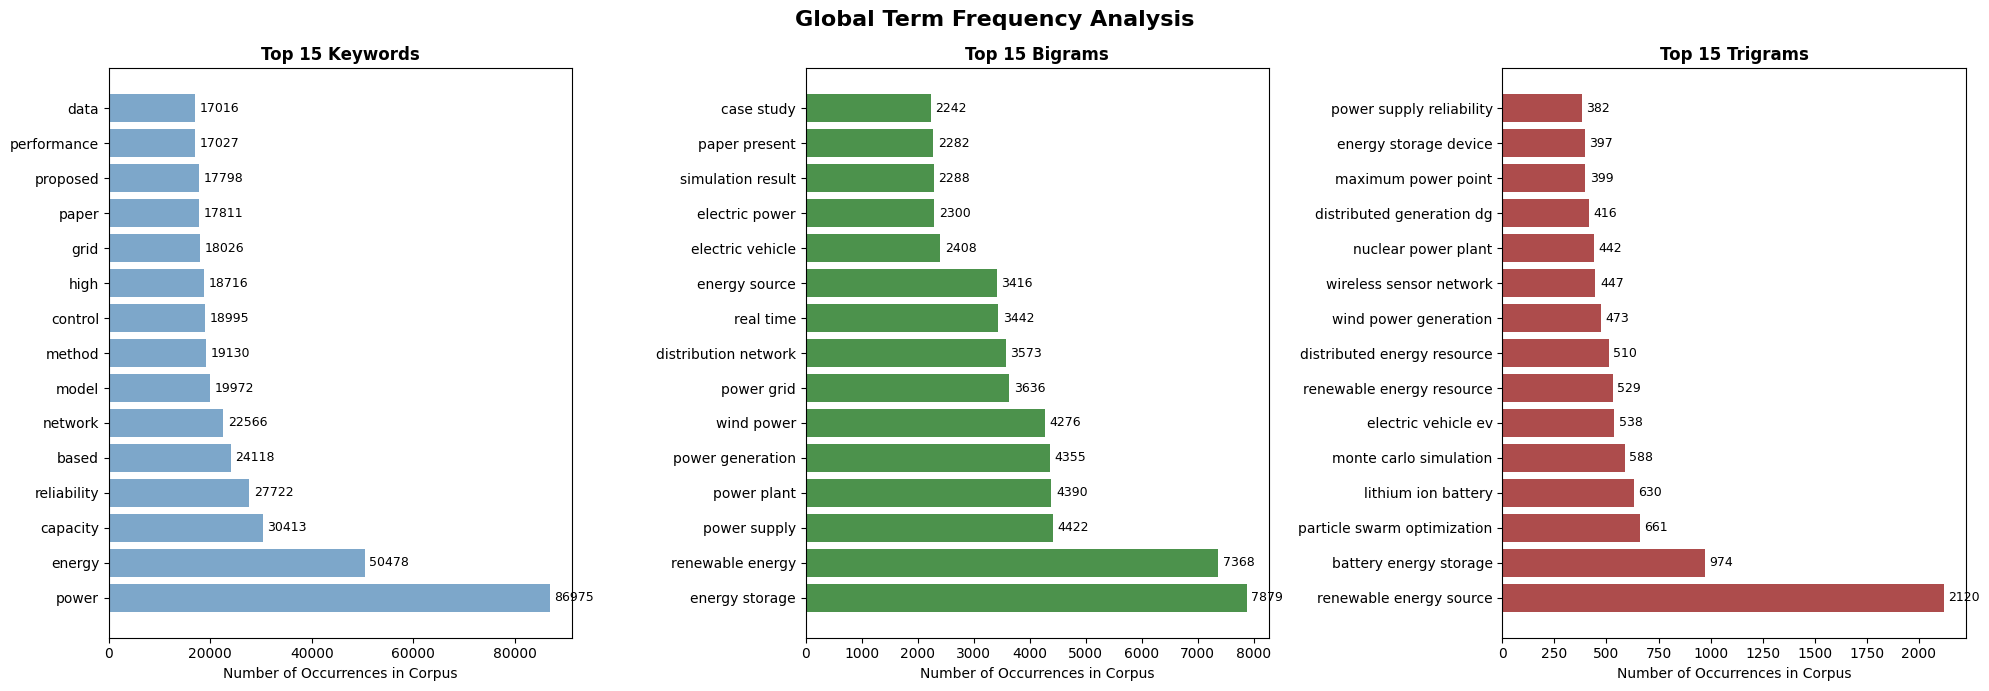

In [77]:
# %%
# Cell 14: Global Term Frequencies Visualization
if data and term_frequencies_file:
    plot_term_frequencies(term_frequencies_file, n_terms=15, save=True)
else:
    print("❌ Term frequencies not available")


### Per-Topic Analysis

📊 Analyzing 2993 documents for topic 7
💾 Per-topic plot saved as: Saved_files_new\topic_7_Resilience_and_Reliability_in_Power_Systems_termfrequencies.png


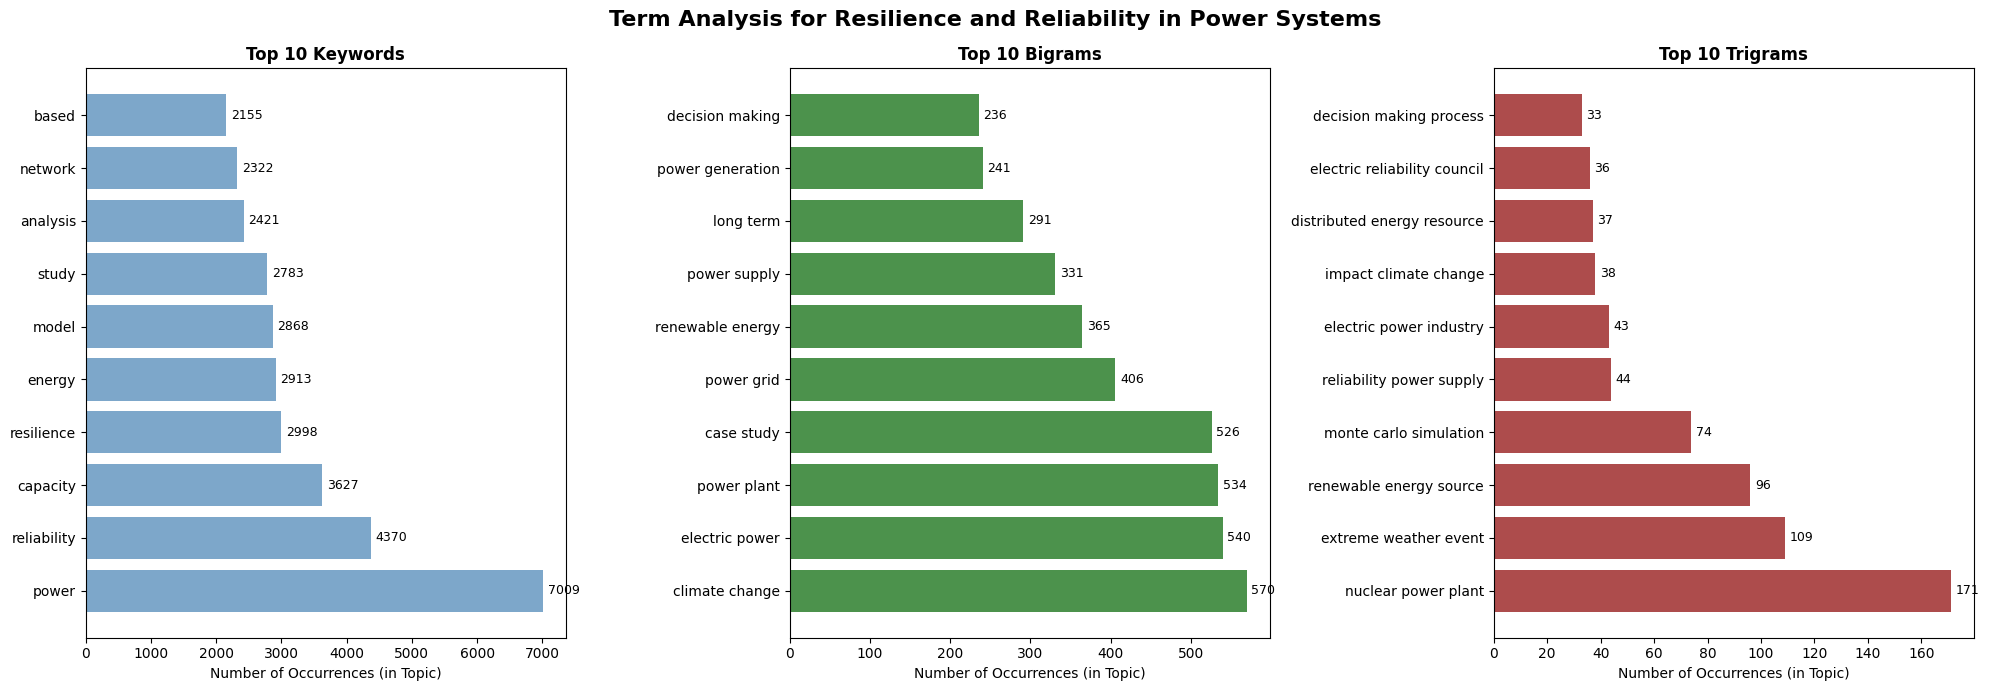

In [78]:
# %%
# Cell 15: Per-Topic Analysis
if data:
    topic_to_plot = 7
    name = topic_names.get(str(topic_to_plot), f"Topic {topic_to_plot}") if topic_names else f"Topic {topic_to_plot}"
    plot_top_terms_for_topic(df, topic_to_plot, topic_name=name, save=True)


### Method Importance

In [79]:
# Print a list of all unique methods present in the method columns of df
unique_methods = set()
for col in method_cols:
    if col.startswith('Method_') and not col.endswith('_Score'):
        unique_methods.update(df[col].dropna().unique())
# Remove invalid entries
unique_methods = [m for m in unique_methods if str(m).lower() not in ['nan', 'none', 'lowconfidence']]
print(f"Unique methods found ({len(unique_methods)}):")

for method in sorted(unique_methods):
    print(method)

Unique methods found (96):
High
Low
adaptive neuro-fuzzy inference system
alternating direction method of multipliers
ant colony optimization
autoregressive integrated moving average
capacity outage probability
customer average interruption duration index
deep reinforcement learning drl
demand response dr
differential evolution
differential protection
discrete wavelet
dynamic condition
dynamic line rating
dynamic programming
dynamic reactive power
dynamic voltage restorer
economic dispatch
fast decoupled power flow
fault tree analysis
firefly algorithm
first order reliability method
fuzzy control
gauss-seidel load flow
generalized autoregressive conditional heteroskedasticity
generation shift factors
hierarchical level ii
hierarchical level iii
incremental conductance
integer linear programming
interior point method
k-means
kalman filter
latin hypercube sampling
line outage distribution factor
linear programming
load flow analysis
load frequency control
load shifting
loss of load proba

📊 Plotting 15 methods


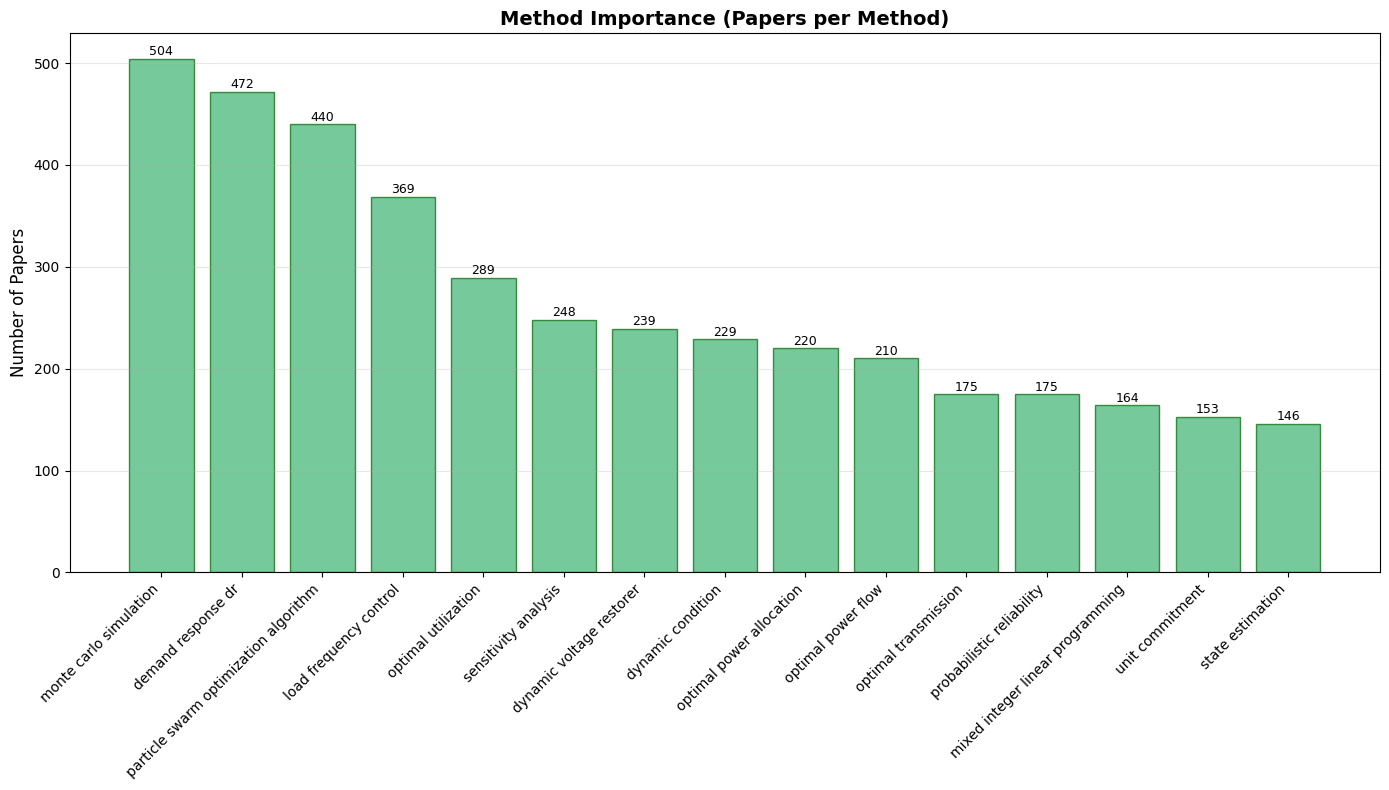

In [80]:
# %%
# Cell 16: Method Importance
if data:
    plot_method_importance(df, max_methods=15, include_low_conf=True
    )


### Topic Importance

In [81]:
print(topic_names)

{'0': 'Thermal Energy Systems', '1': 'Wireless Communication Systems', '2': 'Wireless Sensor Network Applications', '3': 'Smart Data Management', '4': 'Power System Control', '5': 'Wind Energy Optimization', '6': 'Renewable Energy Systems', '7': 'Resilience and Reliability in Power Systems', '8': 'High-Performance Battery Materials', '9': 'Renewable Energy Systems'}


📊 Plotting 9 topics


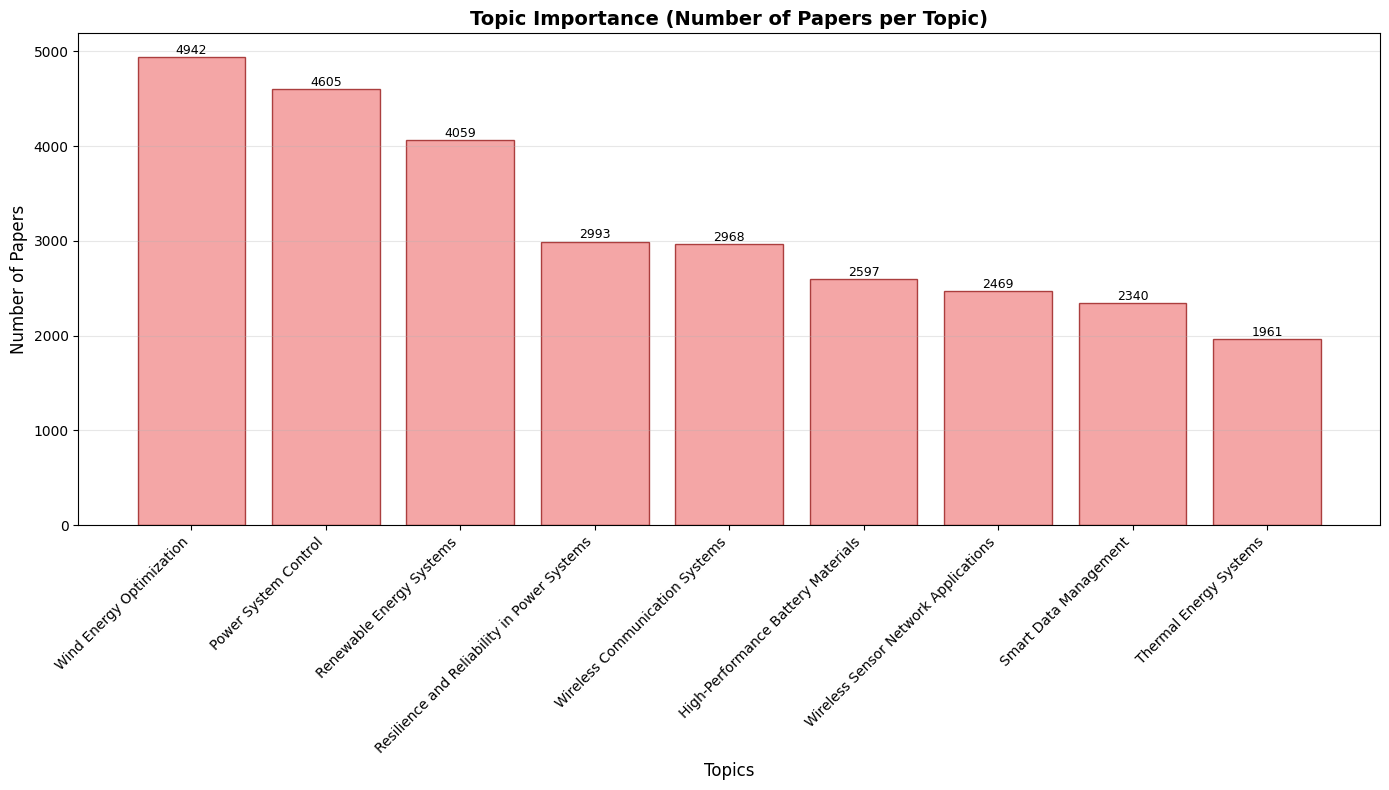

In [82]:
# %%
# Cell 17: Topic Importance
if data:
    plot_topic_importance_with_names(df, topic_names, max_topics=15)


### Method Trends Over Time

📈 Plotting trends for: Top 50 Methods
📊 Papers after all filtering: 6683
📅 Years with ≥20 papers: 24


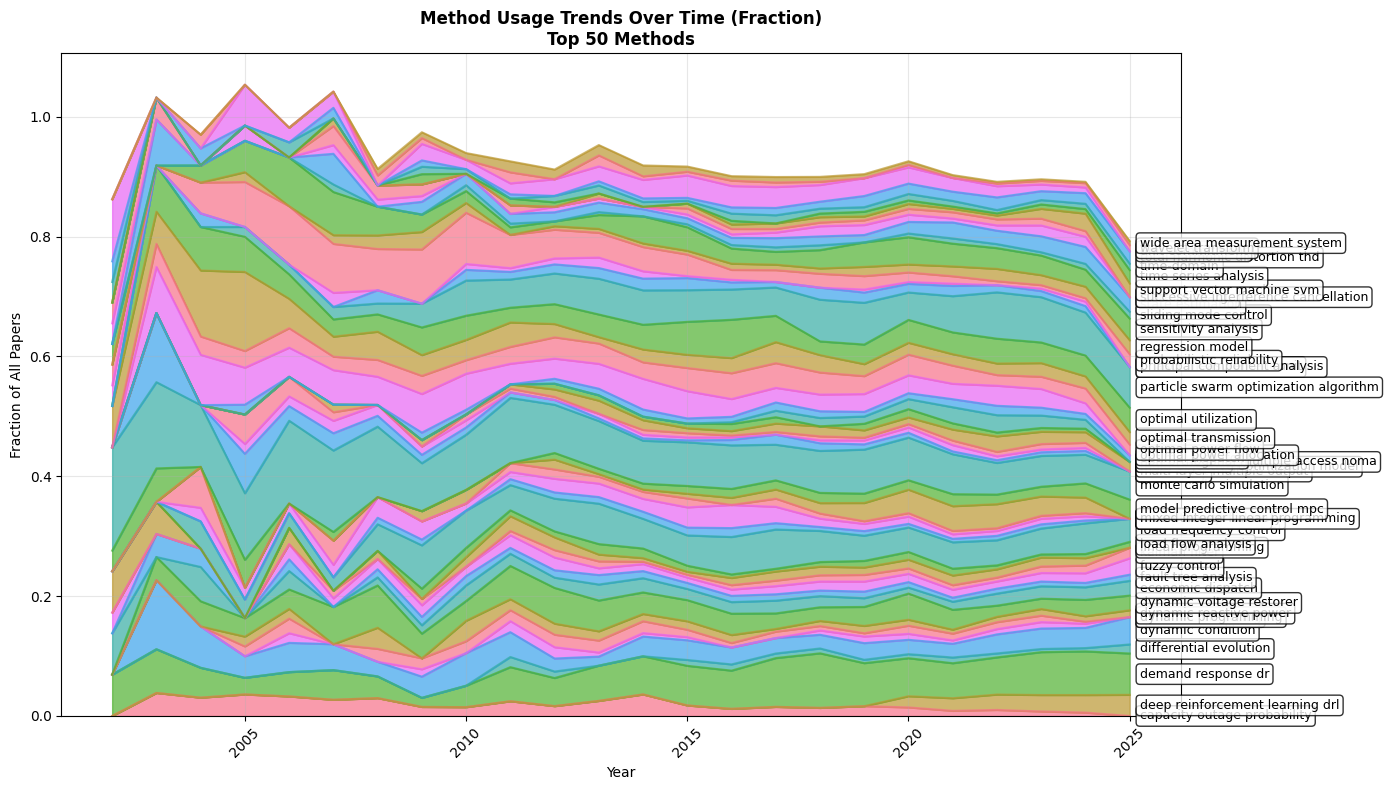

In [83]:
# %%
# Cell 18: Method Trends Over Time
if data:
    plot_method_trends_over_time(df, min_count=1,plot_type='area', window_smooth=2, top_n=50, include_low_conf=True)


### Topic Trends Over Time

In [84]:
#print a list of topic namesas a vertical list
print("\n📚 Loaded Topic Names:")
for idx, name in topic_names.items():
    print(f"  Topic {idx}: {name}")
# print(tolist(topic_names.keys()))


📚 Loaded Topic Names:
  Topic 0: Thermal Energy Systems
  Topic 1: Wireless Communication Systems
  Topic 2: Wireless Sensor Network Applications
  Topic 3: Smart Data Management
  Topic 4: Power System Control
  Topic 5: Wind Energy Optimization
  Topic 6: Renewable Energy Systems
  Topic 7: Resilience and Reliability in Power Systems
  Topic 8: High-Performance Battery Materials
  Topic 9: Renewable Energy Systems


In [85]:
#Plot list of unique venues in the dataframe, skip venues that appear less than 5 times
#Group venues that contain "IEEE", "ACM", "Springer", "Elsevier", "Wiley" into a single group called "Major Publishers"
if 'venue' in df.columns:
    venue_counts = df['venue'].value_counts(dropna=True)
    
    # Define publisher patterns for better matching
    publisher_patterns = {
        'IEEE': ['ieee', 'institute of electrical'],
        'ACM': ['acm', 'association for computing'],
        'Springer': ['springer', 'lecture notes'],
        'Elsevier': ['elsevier', 'science direct'],
        'Wiley': ['wiley', 'john wiley']
    }
    
    def categorize_venue_enhanced(venue):
        if pd.isna(venue) or not isinstance(venue, str):
            return 'Other'
        
        venue_lower = venue.lower()
        
        # Check each publisher with multiple patterns
        for publisher, patterns in publisher_patterns.items():
            if any(pattern in venue_lower for pattern in patterns):
                return f'{publisher}'
        
        # Group small venues
        if venue_counts.get(venue, 0) < 5:
            return 'Small Venues'
        else:
            return venue
    
    df['venue_category'] = df['venue'].apply(categorize_venue_enhanced)
    unique_venues = df['venue_category'].value_counts()
    
    print("\n🏛️ Enhanced Venue Categories:")
    for venue, count in unique_venues.head(10).items():
        print(f"  {venue}: {count} papers")



🏛️ Enhanced Venue Categories:
  Other: 7814 papers
  Small Venues: 6515 papers
  IEEE: 6306 papers
  Energies: 562 papers
  Journal of Physics: Conference Series: 248 papers
  Sustainability: 219 papers
  arXiv.org: 192 papers
  Frontiers in Energy Research: 150 papers
  ECS Meeting Abstracts: 149 papers
  Applied Sciences: 129 papers


📅 Year range: 1980 - 2024
📈 Plotting trends for: Top 10 Topics
📊 Papers after all filtering: 28336
📅 Years with ≥1 papers: 45


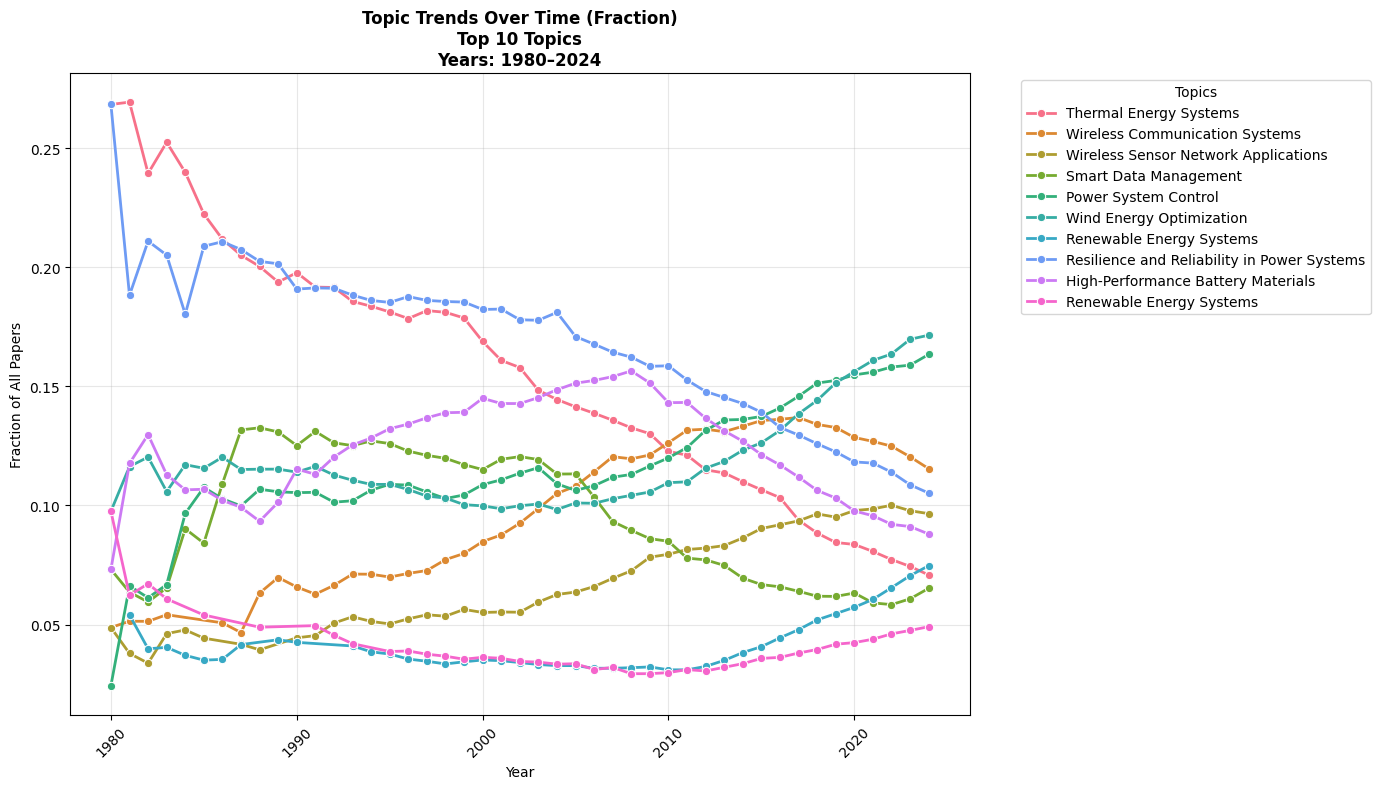

📊 Citation filter: 9411/28336 papers (≥5 citations)
📅 Year range: 1980 - 2024
📈 Plotting trends for: Thermal Energy Systems, Smart Data Management, Power System Control, Wind Energy Optimization, Renewable Energy Systems, Resilience and Reliability in Power Systems
📊 Papers after all filtering: 5990
📅 Years with ≥20 papers: 34


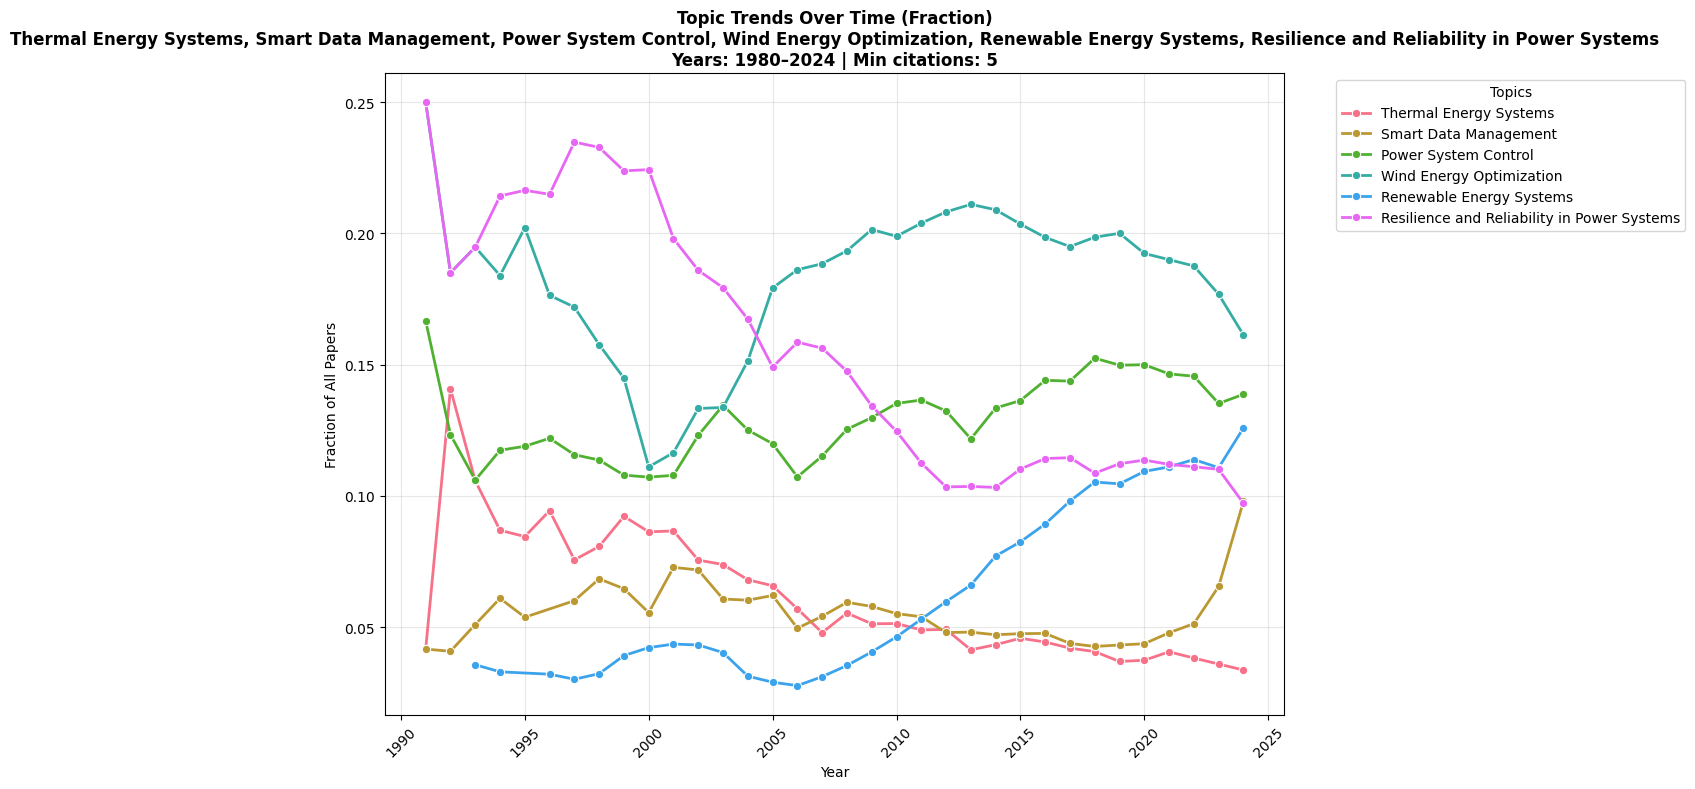

,year,Primary_Topic_Index,count,total_count,value
0,1991,0,1,24,0.041667
5,1992,0,6,25,0.140833
10,1993,0,1,28,0.105794
16,1994,0,1,33,0.086921
22,1995,0,3,40,0.084537
...,...,...,...,...,...
175,2020,7,103,794,0.113659
181,2021,7,77,702,0.112021
187,2022,7,57,573,0.111113
193,2023,7,45,481,0.110132


In [86]:
# %%
# Cell 19: Topic Trends Over Time - Explicit Column
if data:
    result = plot_topic_trends_over_time(
        df, 
        topic_col='Primary_Topic_Index',  # ✅ Explicitly use the Index column
        #topics=[0,3,7,8],  # List of topic indices to plot decreasing
        #topics=[4,5,6,9],  # List of topic indices to plot increasing
        #topics=[1,2], # Listof topic indices to plot stable
        topic_names=topic_names, 
        min_papers_per_year=1,
        plot_type='line', # 'line' or 'area'
        value_type='fraction',  # 'fraction' or 'count'
        window_smooth=20,
        start_year=1980,
        end_year=2024
    )
"""
# %%
# Example 1: Fraction-based area plot (default behavior)
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='fraction',  # Shows percentages
    start_year=2000,
    end_year=2024
)

# Example 2: Absolute count-based area plot
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,1,2,3,4],
    topic_names=topic_names, 
    plot_type='area',
    y_axis='count',  # Shows absolute numbers
    start_year=2000,
    end_year=2024
)
"""
#Line plot with full topic names in legend
plot_topic_trends_over_time(
    df, 
    topic_col='Primary_Topic_Index',
    topics=[0,3,4,5,6,7],
    topic_names=topic_names, 
    plot_type='line',
    value_type='fraction',
    start_year=1980,
    window_smooth=5,
    min_citations=5,
    end_year=2024
)

### Weighted Method Importance

🔍 Starting Enhanced Method Importance Analysis with Filtering...

📊 Filtering Results:
  Original papers: 28,934
  After Min citations (≥5): 9486 papers
  After Min year (≥1980): 9411 papers
  After Max year (≤2024): 9411 papers
  Final papers: 9,411 (32.5% retained)
📊 Using method columns: ['Method_1', 'Method_2', 'Method_3', 'Method_4', 'Method_5', 'Method_6', 'Method_7', 'Method_8', 'Method_9', 'Method_10']
📊 Plotting top 25 methods


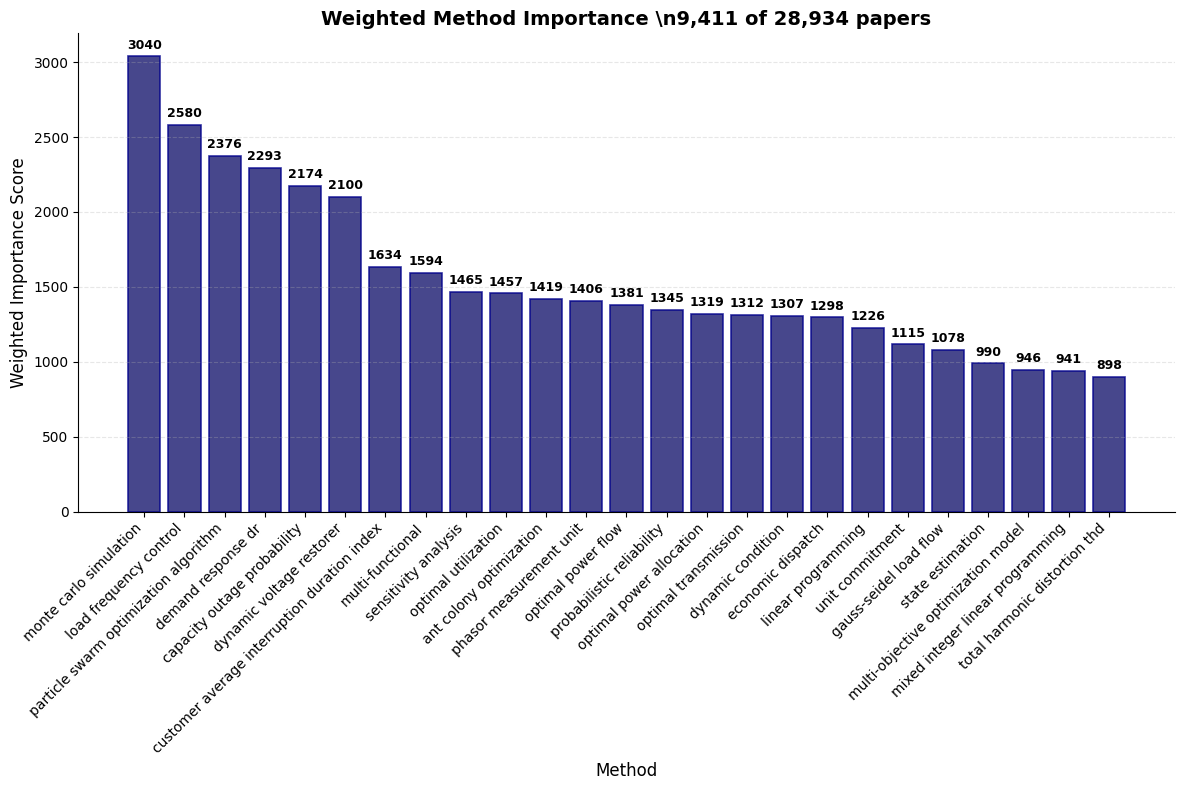


📈 Summary Statistics:
  Total methods identified: 93
  Methods displayed: 25
  Score range: 898 - 3040
  Mean score: 1547.8


In [93]:
# %%
# Cell 20: Weighted Method Importance
"""def plot_weighted_method_importance_filtered(df, 
                                           n_top=5, 
                                           plot_top_k=None, 
                                           method_label_prefix="Method_",
                                           # NEW: Simplified Topic Filtering by Number
                                           topic_numbers=None,          # Filter by topic number(s) - list or single int
                                           min_citations=None,          # Minimum citation count
                                           max_citations=None,          # Maximum citation count
                                           venues_include=None,         # List of venues to include
                                           venues_exclude=None,         # List of venues to exclude
                                           min_year=None,              # Minimum publication year
                                           max_year=None,              # Maximum publication year
                                           # Visualization Parameters
                                           figsize=(14, 8),
                                           save_dir=None,
                                           show_filter_info=True):"""

if data:
    weighted_results = plot_weighted_method_importance_filtered(df, n_top=10, plot_top_k=25, figsize=(12,8), min_year=1980, max_year=2024, min_citations=5)


### Weighted Method Trends

📊 Citation filter: 4321/28532 papers (≥15 citations)


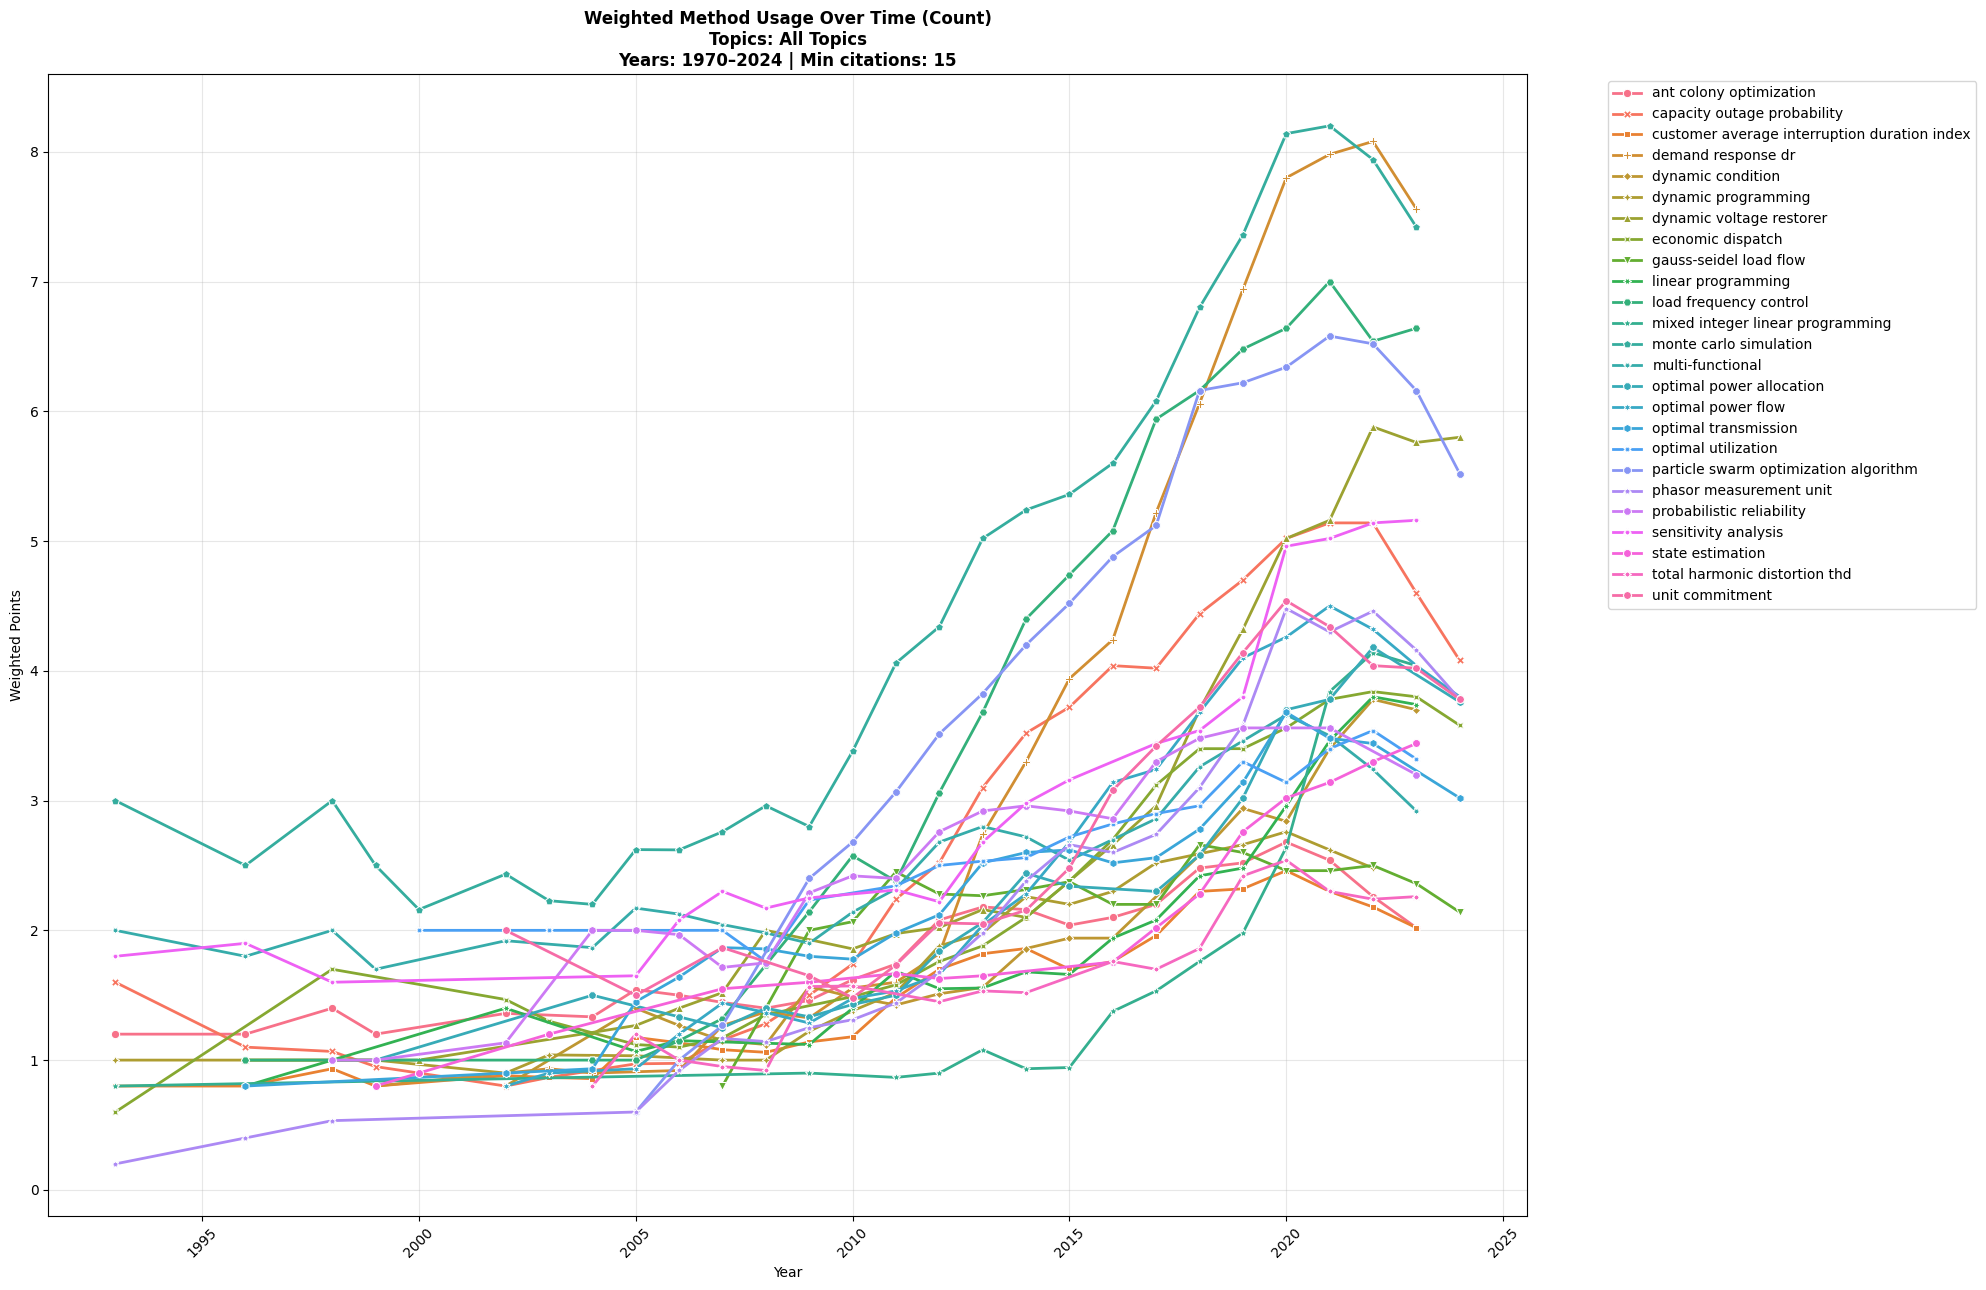

In [92]:
# %%
# Cell 21: Weighted Method Trends
plot_top_k=25
#adjust fig height to method count / 2 +3 and round up to nearest integer
fig_height = min(int((plot_top_k / 3) + 5),20)

if data:
    plot_weighted_method_trends_over_time(
        df, n_top=5, plot_top_k=plot_top_k, 
        start_year=1970, end_year=2024, 
        min_papers_per_year=5,
        plot_type='line',
        value_type='count',
        min_citations=15, 
        window_smooth=10,
        #methods=["monte carlo simulation"],
        figsize=(20, fig_height),
        log_scale=False
        
    )


### Topic-Specific Method Trends

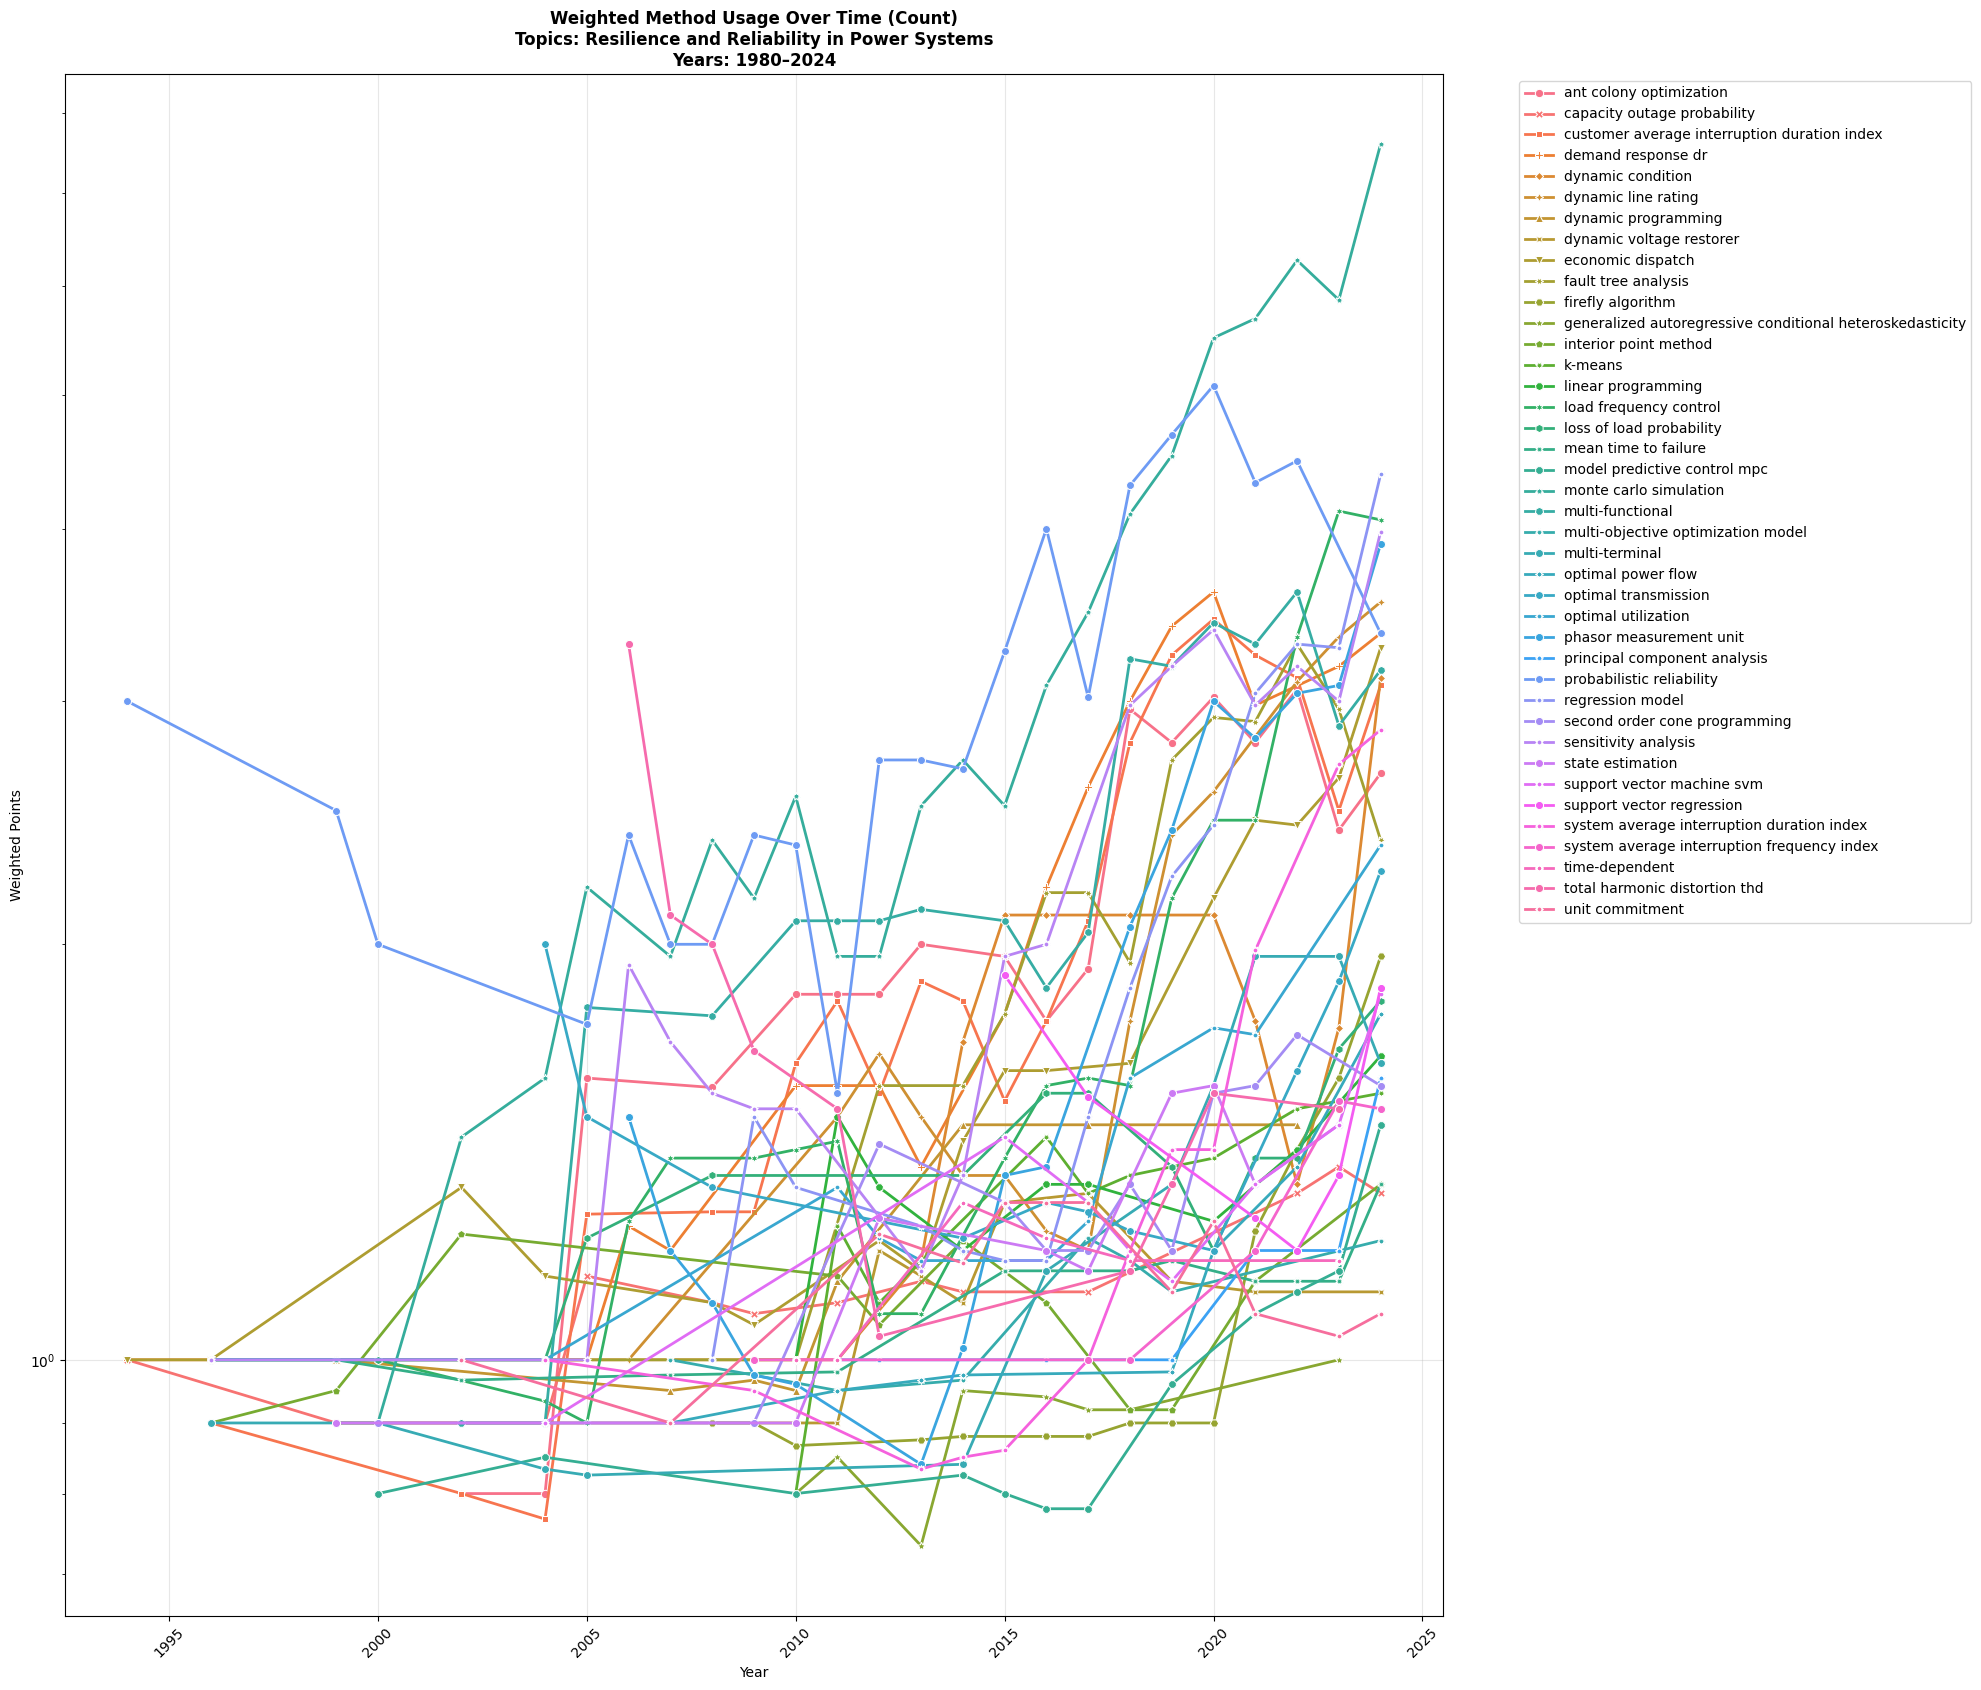

In [89]:
# %%
# Cell 22: Topic-Specific Method Trends
plot_top_k=40
#adjust fig height to method count / 2 +3 and round up to nearest integer
fig_height = int((plot_top_k / 4) + 7)
if data:
    plot_weighted_method_trends_over_time(
        df, n_top=10, 
        topics=[7], 
        topic_names=topic_names,
        start_year=1980, end_year=2024, 
        min_papers_per_year=5, 
        plot_top_k=plot_top_k,
        plot_type='line', window_smooth=5,
        value_type='count',  # 'fraction' or 'count'
        log_scale=True,
        figsize=(20, fig_height),
        #min_citations=5,
        #venues=['IEEE Transactions on Power Systems', 'IEEE Transactions on Smart Grid', 'Electric Power Systems Research'],
        #methods=['Probabilistic risk assesment', 'probabilistic reliability evaluation']
    )


### Basic Topic-Method Heatmap

📊 Creating heatmap for 5 topics and 25 methods


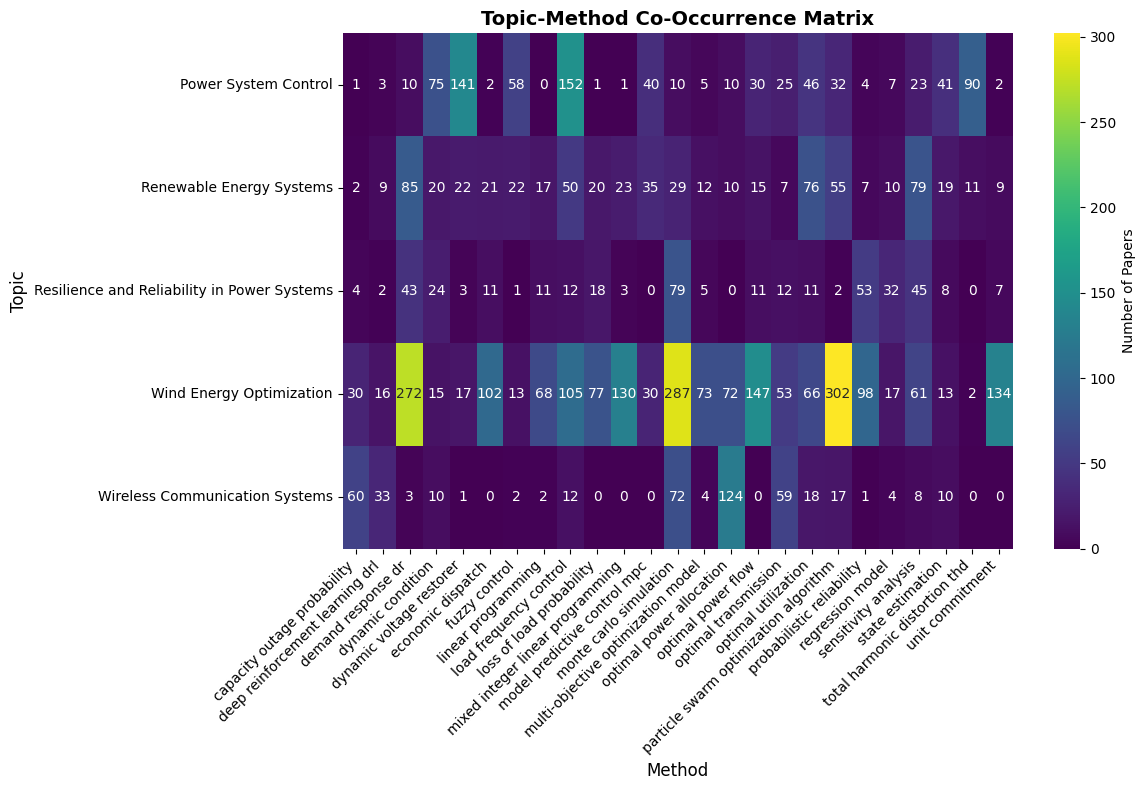

In [90]:
# %%
# Cell 23: Basic Topic-Method Heatmap
if data:
    plot_topic_method_heatmap(df, top_n_methods=25, top_n_topics=5)


In [91]:
# %%
# Cell 24: Advanced Weighted Heatmap
if data:
    pivot = plot_weighted_topic_method_heatmap(
        df, n_top=5, topics=[3,7,9], topic_names=topic_names,
        start_year=2000, end_year=2022, min_papers_per_year=5,
        plot_top_methods=8, plot_top_topics=8
    )

print("\n🎉 Visualization complete! All plots have been generated.")


📊 Creating heatmap from 4319 papers

🎉 Visualization complete! All plots have been generated.
